## Preliminaries

In [1]:
import cv2
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [25, 15]

## Load data and helper function

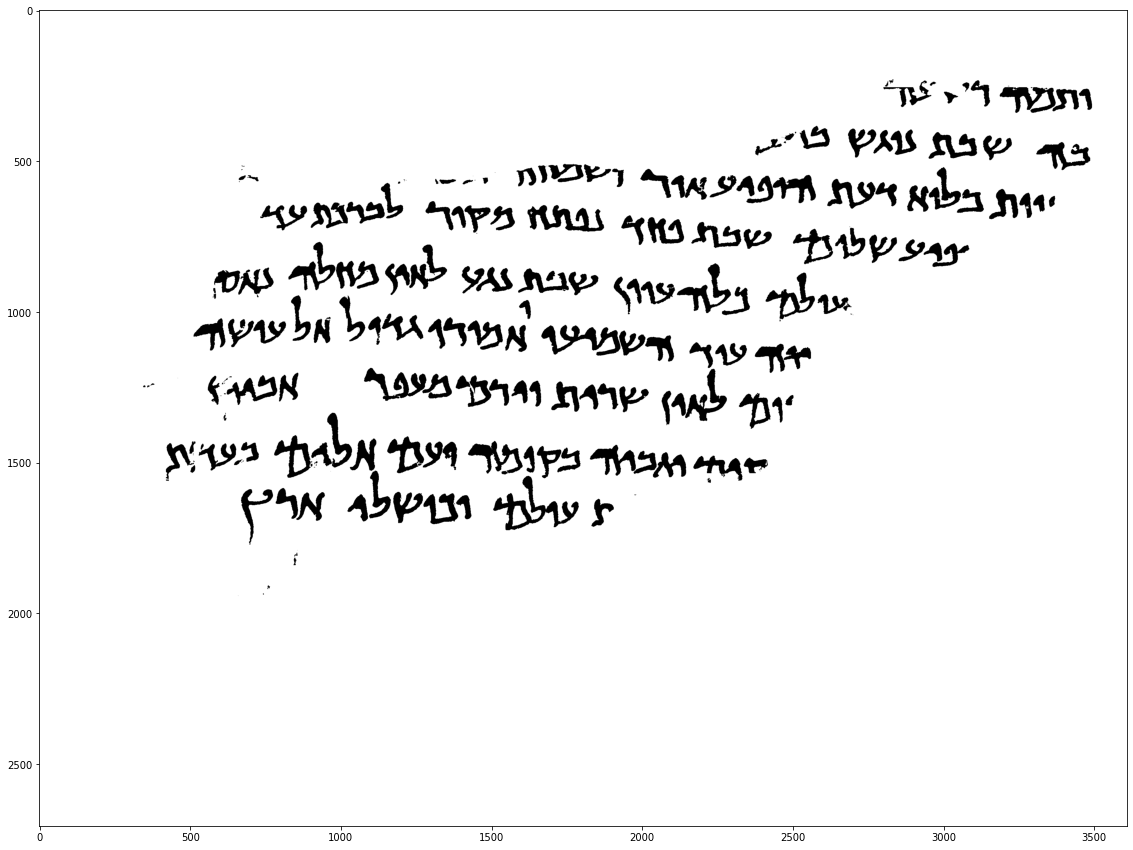

In [2]:
img = cv.imread('../data/dss/scrolls/P513-Fg001-R-C01-R01-binarized.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
ret, img = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)
plt.imshow(img, 'binary')
img_c = cv.cvtColor(img, cv.COLOR_GRAY2RGB)

def pimg(im, **kwargs):
    try:
        cim = cv.cvtColor(im, cv.COLOR_GRAY2RGB)
    except:
        cim = im
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(cim, **kwargs)
    plt.show()

## Training data heuristics

In [22]:
from pathlib import Path
td = Path('../data/dss/characters')
files = td.glob('*/*.pgm')
chars = [cv.imread(str(file)) for file in files]

In [24]:
chars_s0 = [char.shape[0] for char in chars]
chars_s1 = [char.shape[1] for char in chars]
print(max(chars_s0))
print(max(chars_s1))

77
196


## Add connected components

In [9]:
from dataclasses import dataclass

@dataclass
class ConnectedComponent:
    x: int
    y: int
    w: int
    h: int
    a: int
    cx: float
    cy: float

def prep_ccs(ccs_data):
    _, _, stats, centroids = ccs_data
    return [
        ConnectedComponent(*stat, *centroids[i])
        for i, stat in enumerate(stats)
    ]

def get_cc_img(cc):
    return img[cc.y:cc.y+cc.h, cc.x:cc.x+cc.w]

ccs = prep_ccs(cv.connectedComponentsWithStats(img))
del ccs[0]

In [28]:
large_ccs = [cc for cc in ccs if cc.w > 110]
print(len(large_ccs))

39


In [67]:
img.shape[1::-1]

(3608, 2706)

In [97]:
from peakdetect import peakdetect
from scipy import ndimage

def get_horiz_bound(cc):
    ccim = get_cc_img(cc)
    acc = cv.reduce(ccim//255, 0, cv.REDUCE_SUM, dtype=cv.CV_32S)[0]
    maxima, minima = peakdetect(acc, lookahead=30)
    return minima

def filter_minima(minima):
    res = []
    for i, mn in enumerate(minima):
        if mn[1] < 10000:
            w = ccimg.shape[0]
            prev = res[-1] if len(res)>0 else [0]
            if mn[0] - prev[0] > 30:
                res.append(mn)
    return res



def bounds_with_rot(cc):
    ccim = get_cc_img(cc)
    min_val = np.Inf
    min_angle = 0
    min_acc = []
    for angle in range(-45, 45, 2):
        rccim = ndimage.rotate(ccim, angle)
        acc = cv.reduce(rccim//255, 0, cv.REDUCE_SUM, dtype=cv.CV_32S)[0]
        _, minima = peakdetect(acc, lookahead=30)
        minima = filter_minima(minima)
        cmin = min([mn[0] for mn in minima]) if minima else np.Inf
        print(cmin)
        if cmin < min_val:
            min_val = cmin
            min_angle = angle
            min_acc = acc
    maxima, minima = peakdetect(min_acc, lookahead=30)
    return min_angle, minima

110
111
108
125
124
123
123
121
120
119
117
117
114
113
112
inf
inf
inf
inf
inf
inf
67
67
66
70
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf


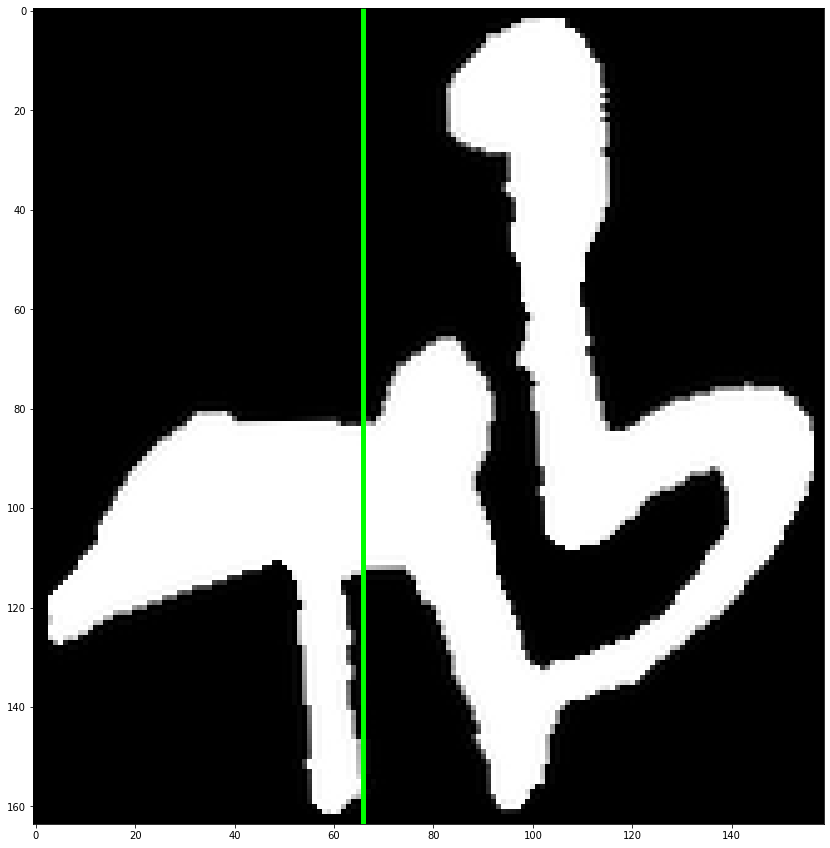

In [98]:
a, minima = bounds_with_rot(large_ccs[14])
rot = ndimage.rotate(cv.cvtColor(get_cc_img(large_ccs[14]), cv.COLOR_GRAY2RGB), a)
for mn in minima:
    cv.line(rot, (mn[0], 0), (mn[0], 1000), (0, 255, 0), 1)
pimg(rot)

[[42, 3], [112, 10]]


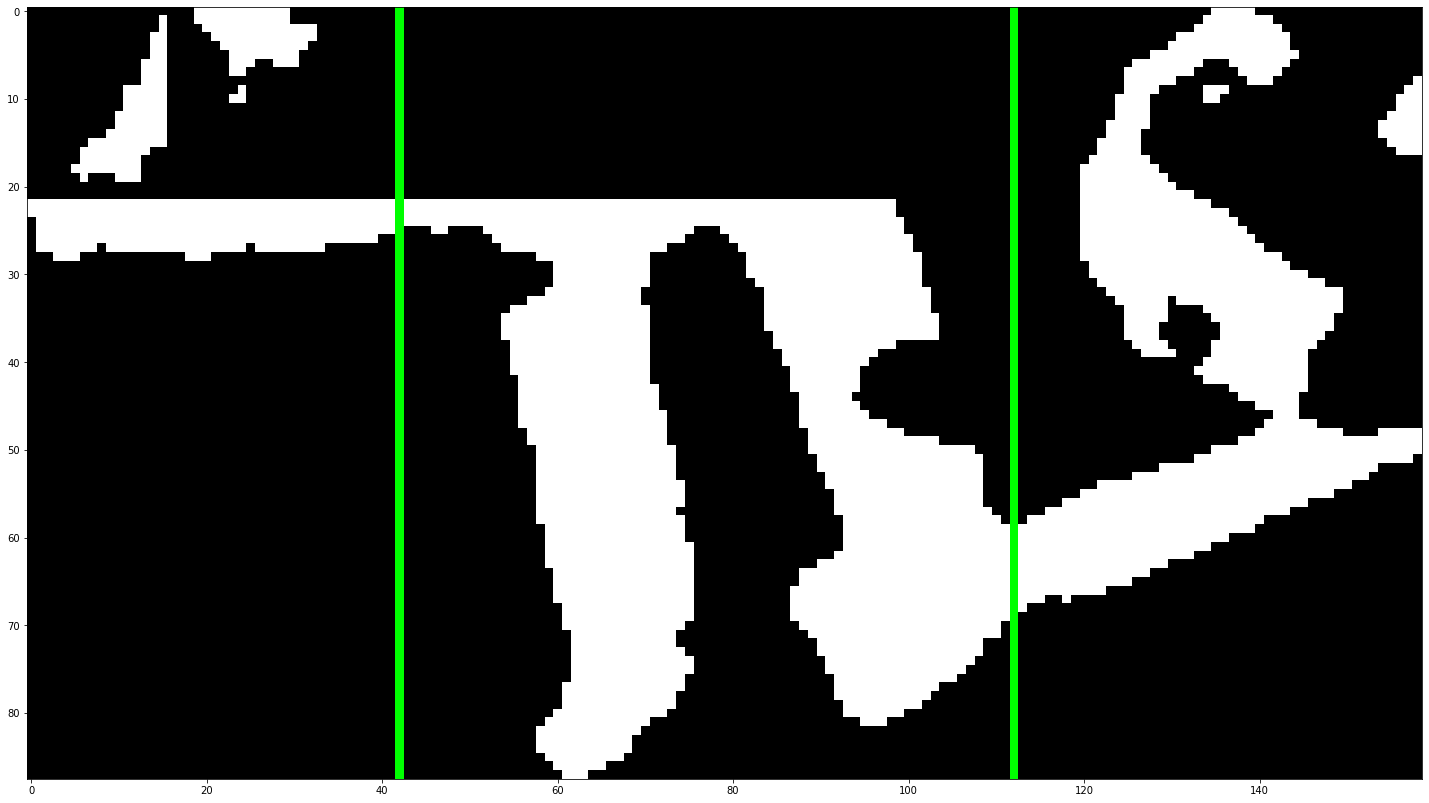

[[75, 29], [108, 30], [151, 21]]


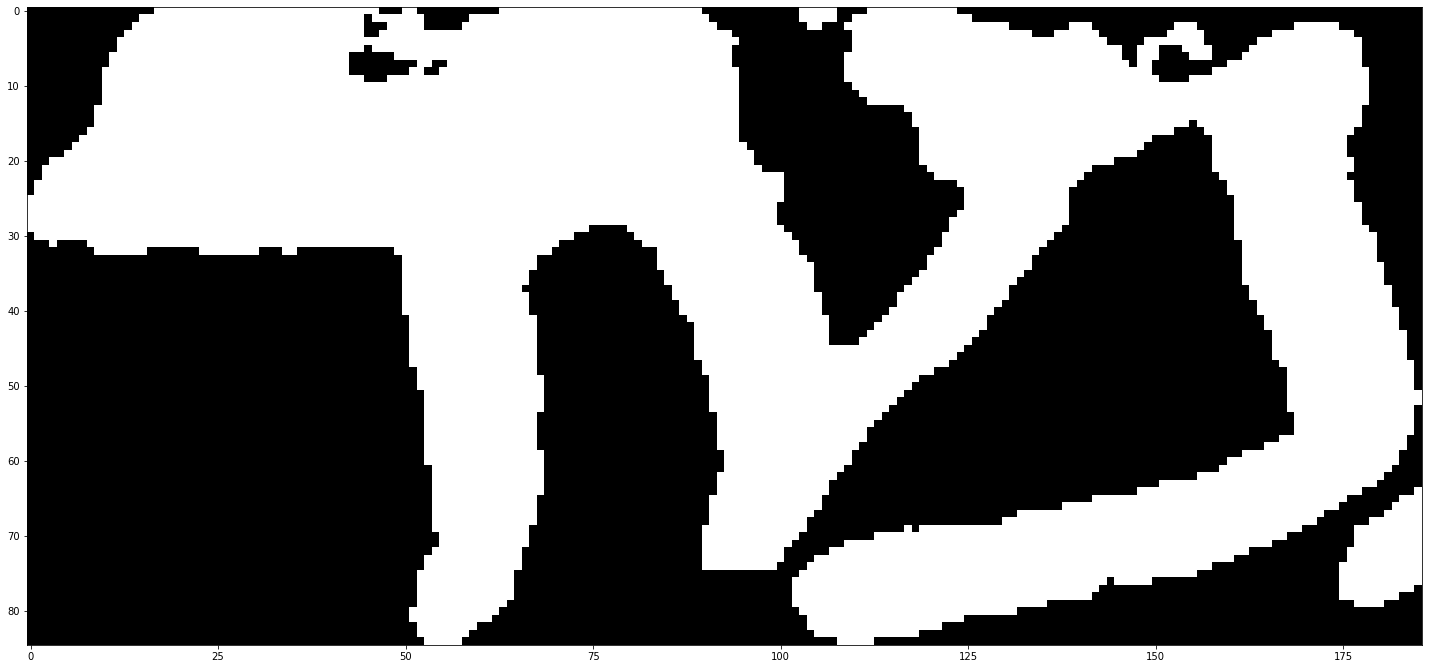

[[55, 21], [95, 14]]


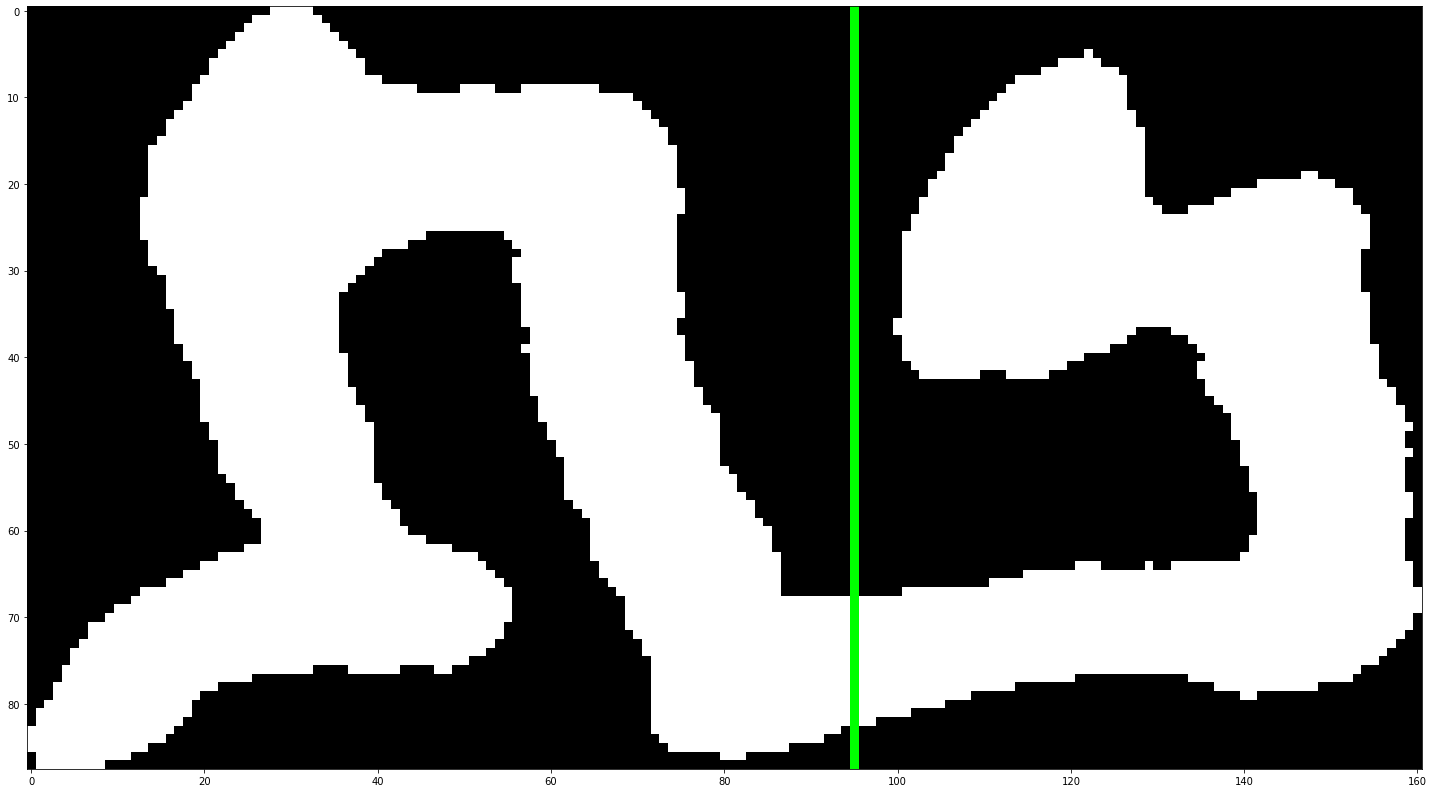

[[113, 12]]


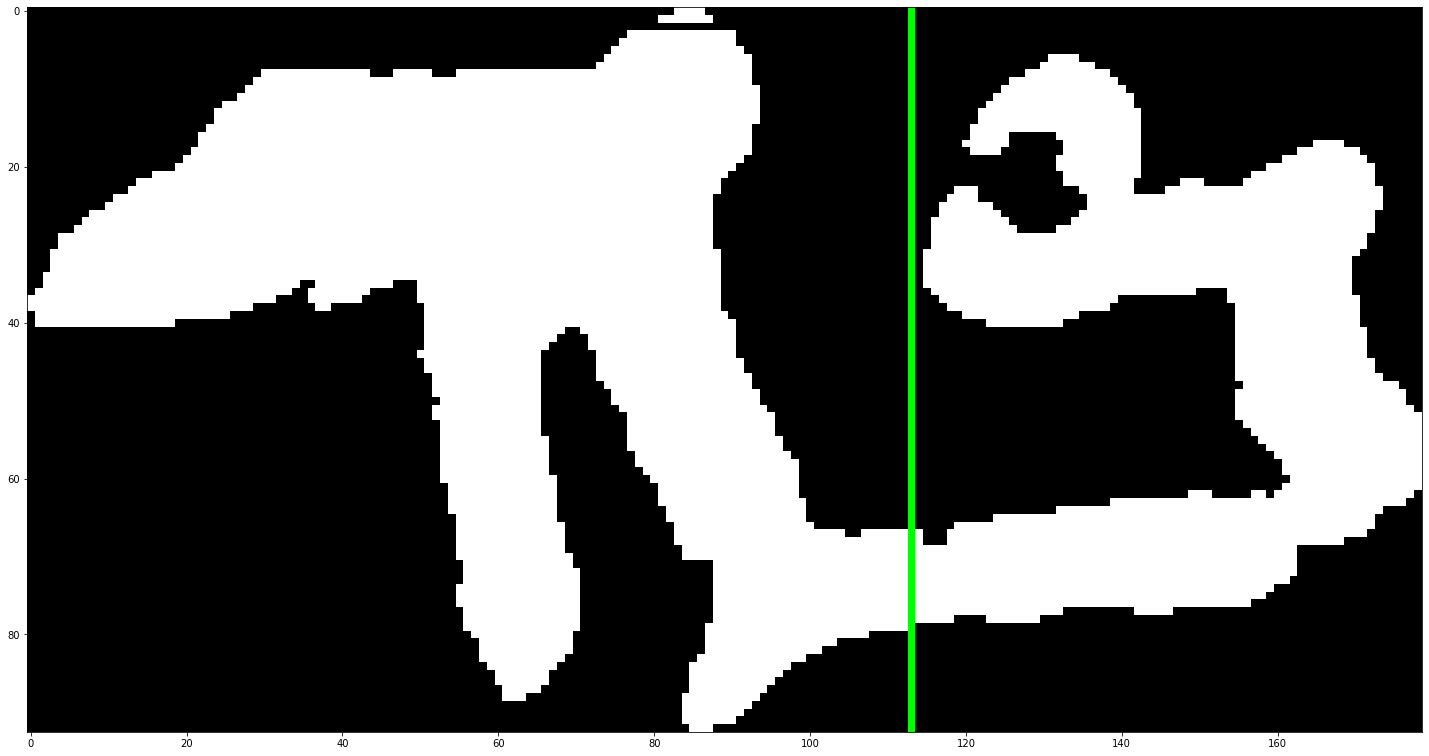

[]


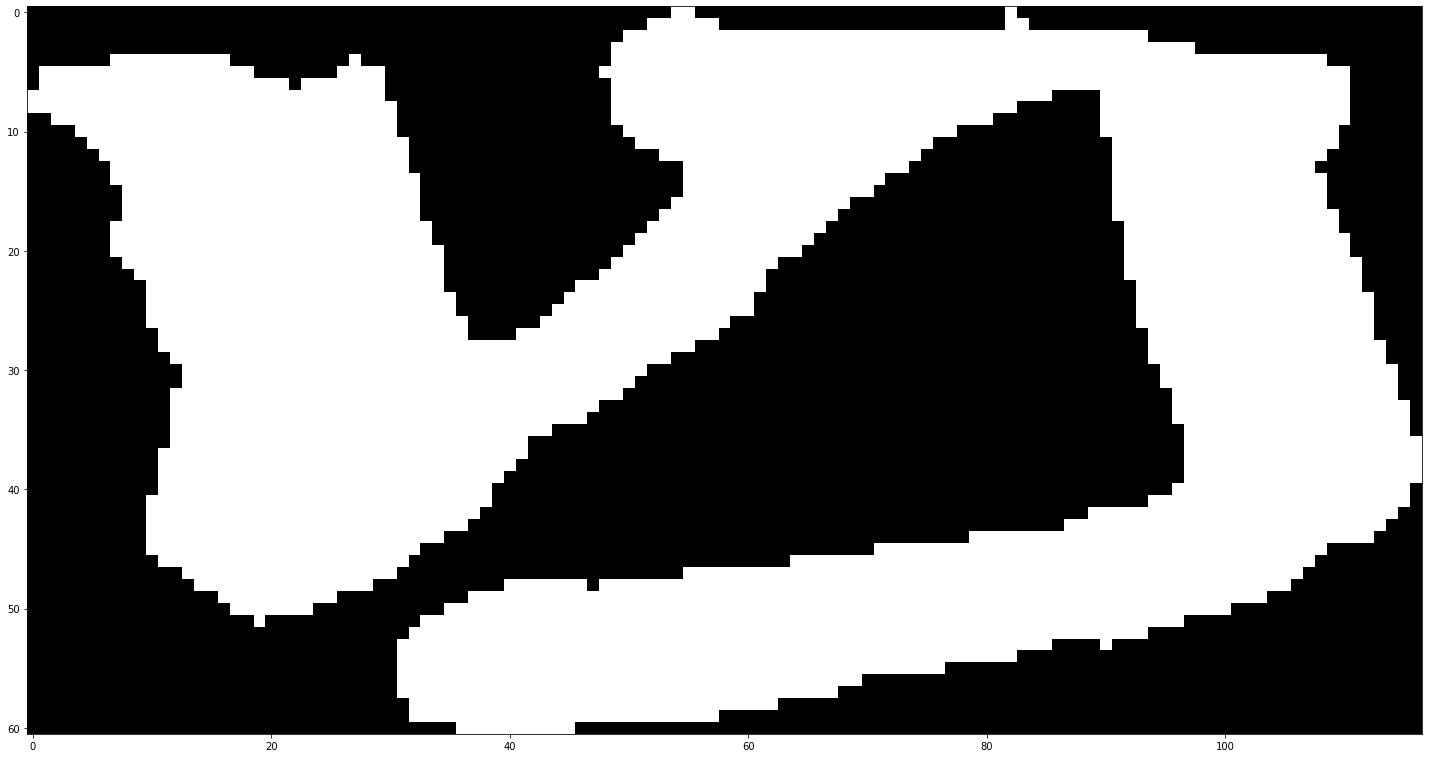

[[47, 17]]


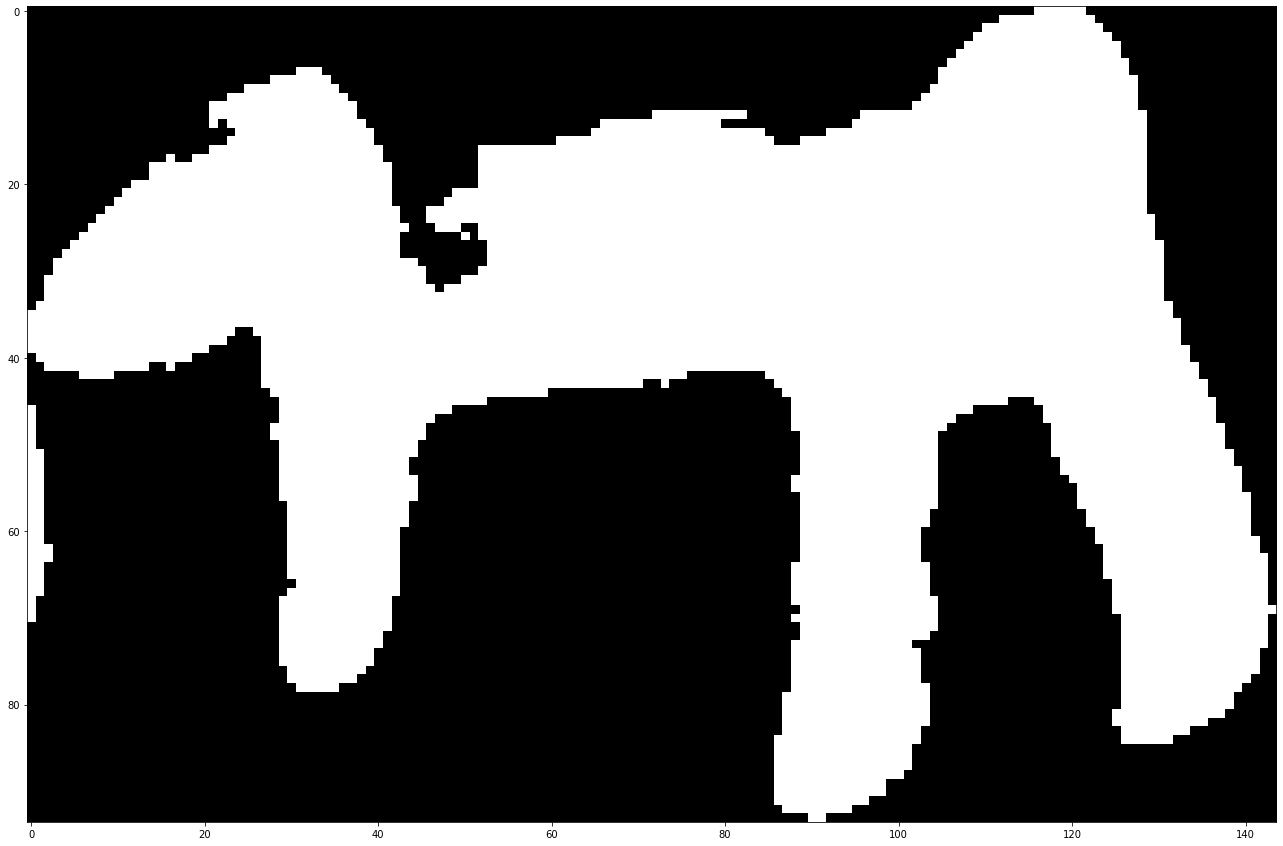

[[53, 17], [94, 11]]


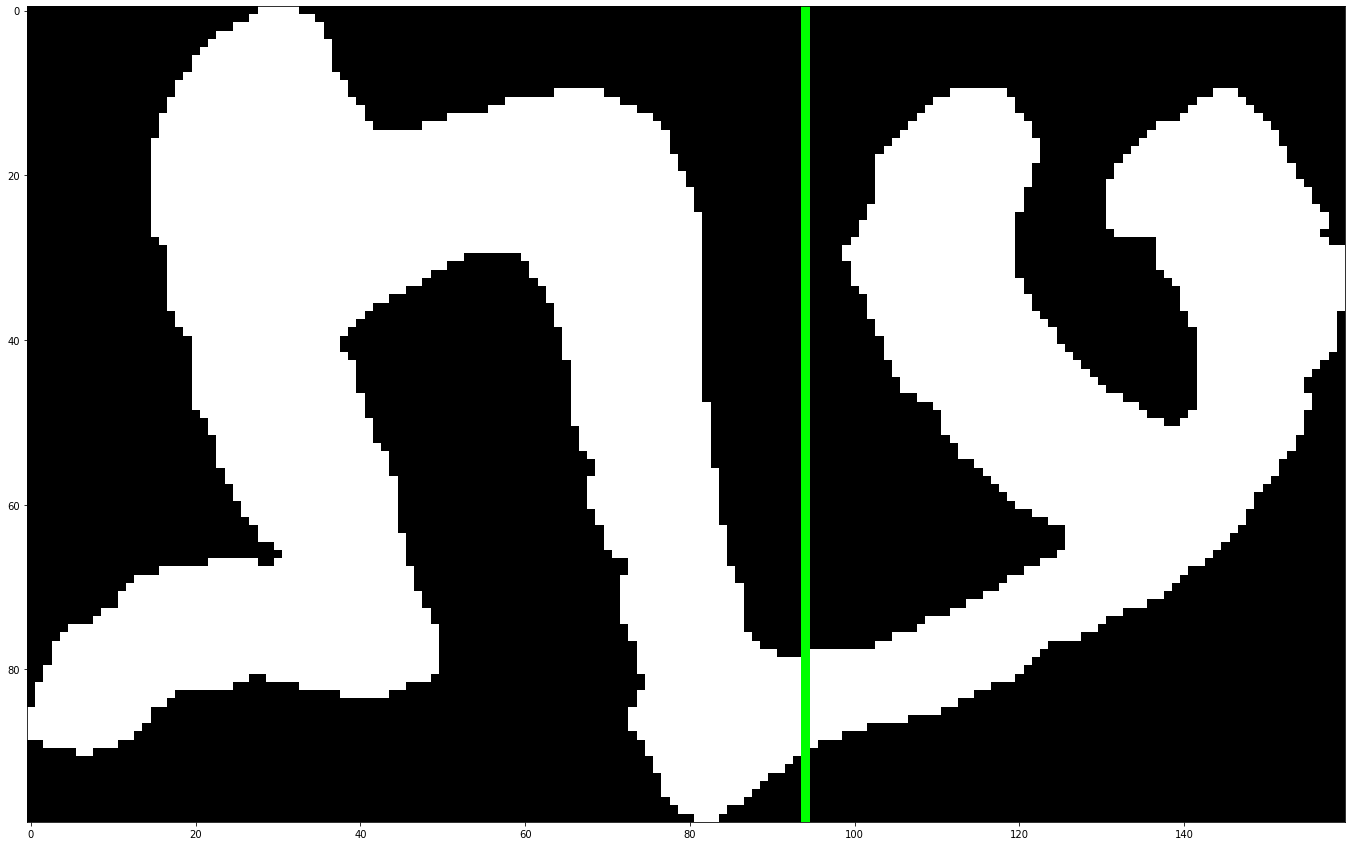

[[23, 14], [61, 14]]


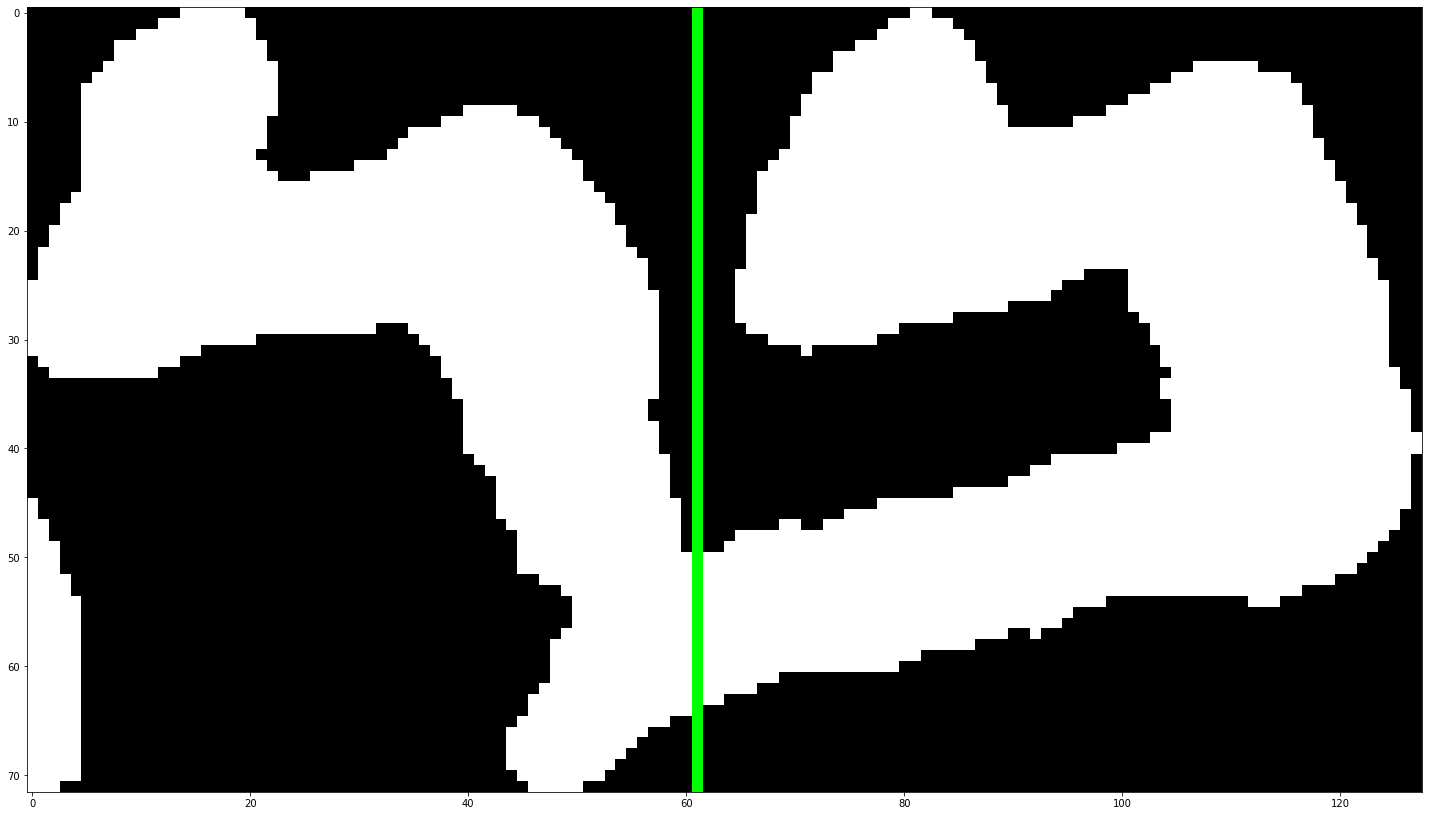

[[44, 22], [69, 23]]


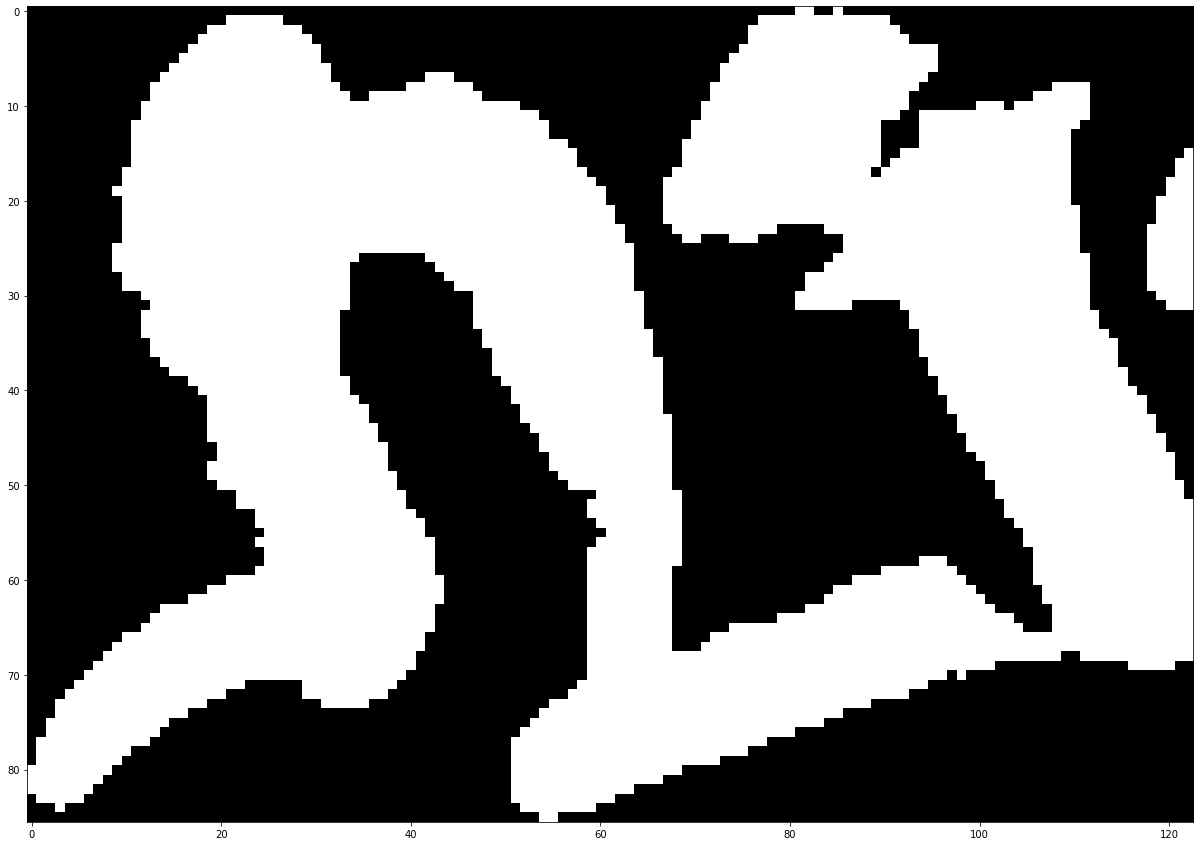

[[84, 9]]


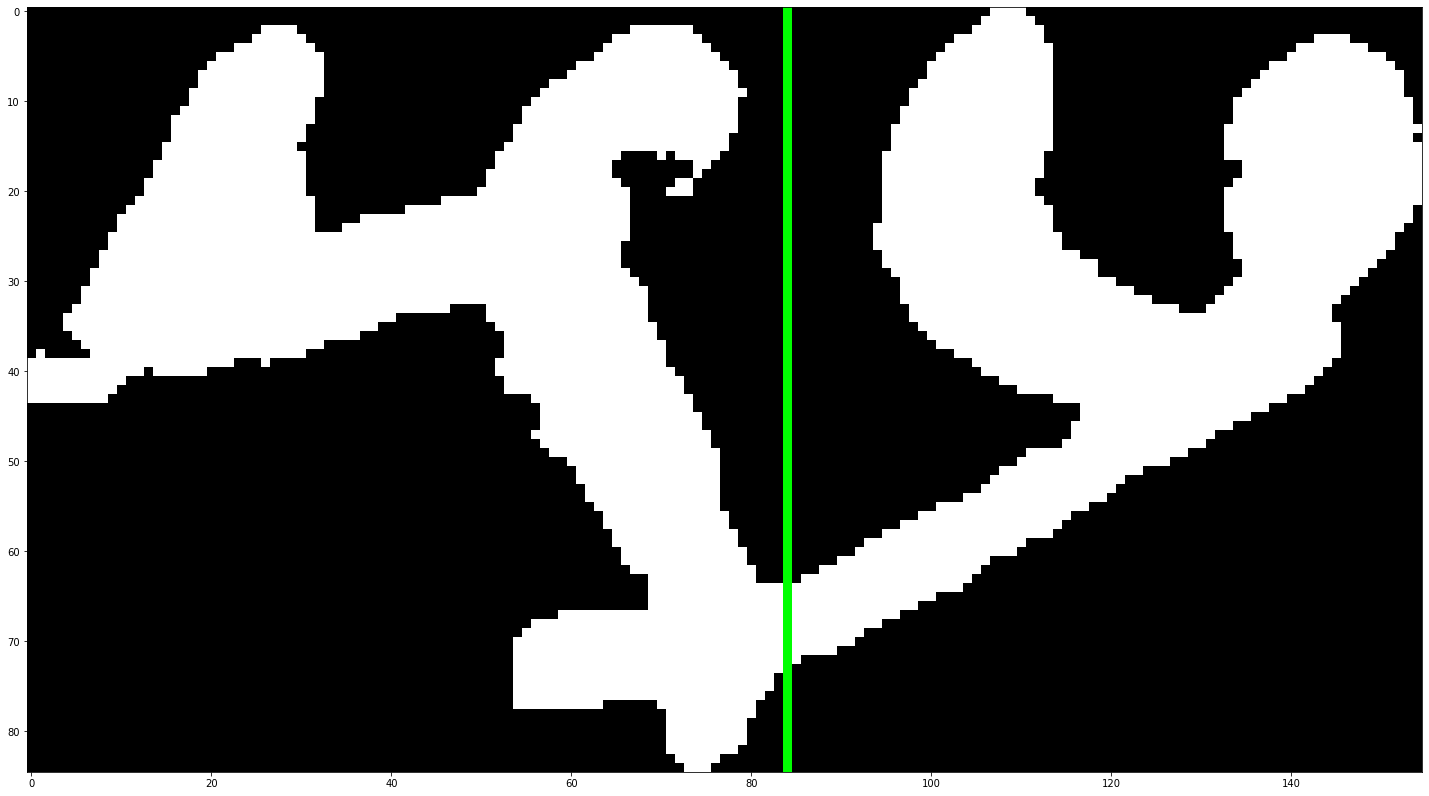

[[31, 16], [77, 12], [119, 19], [156, 13]]


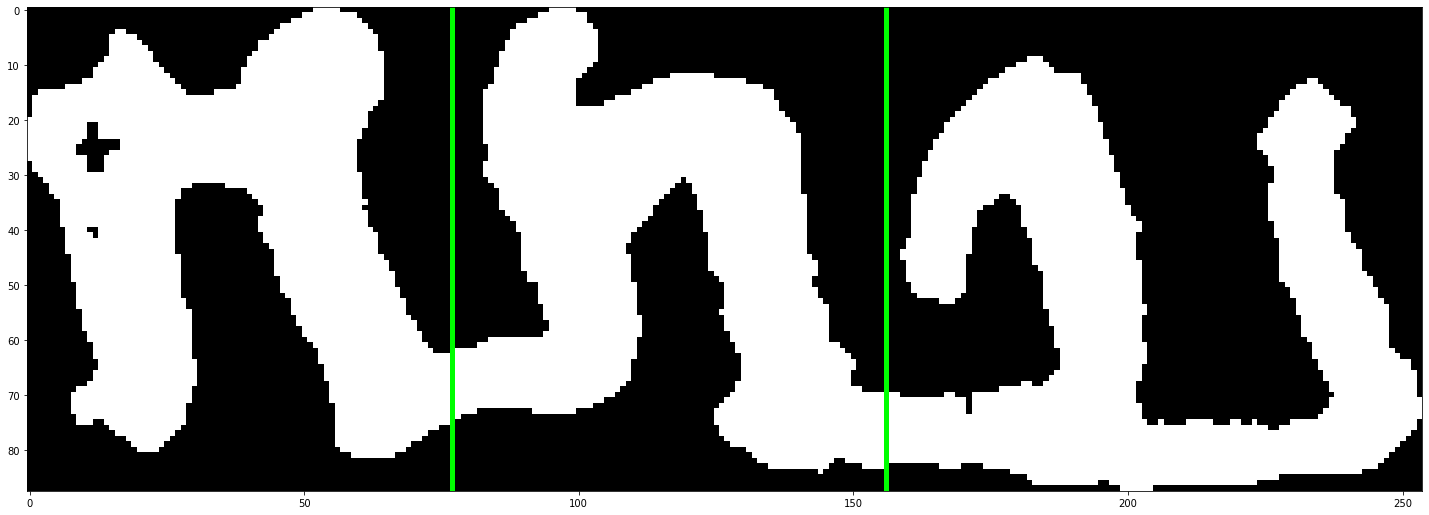

[[30, 17], [64, 14]]


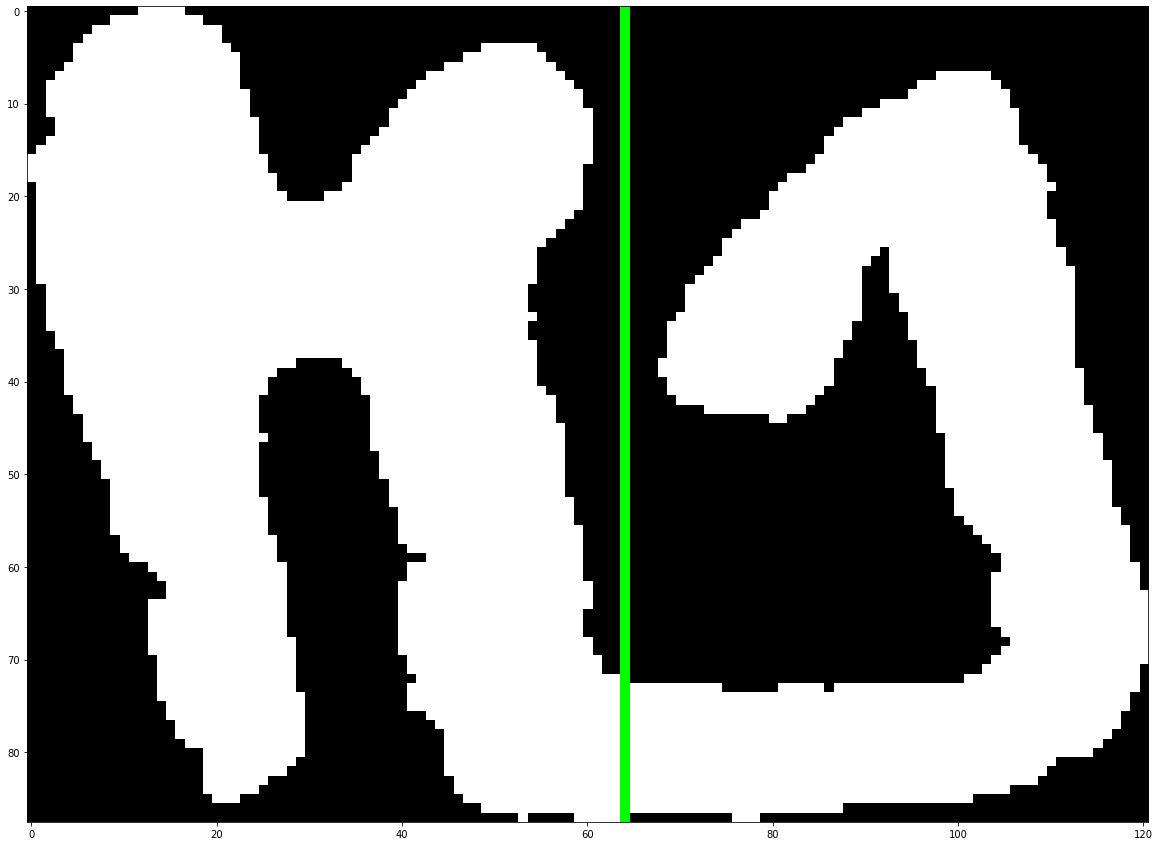

[[51, 11], [93, 10]]


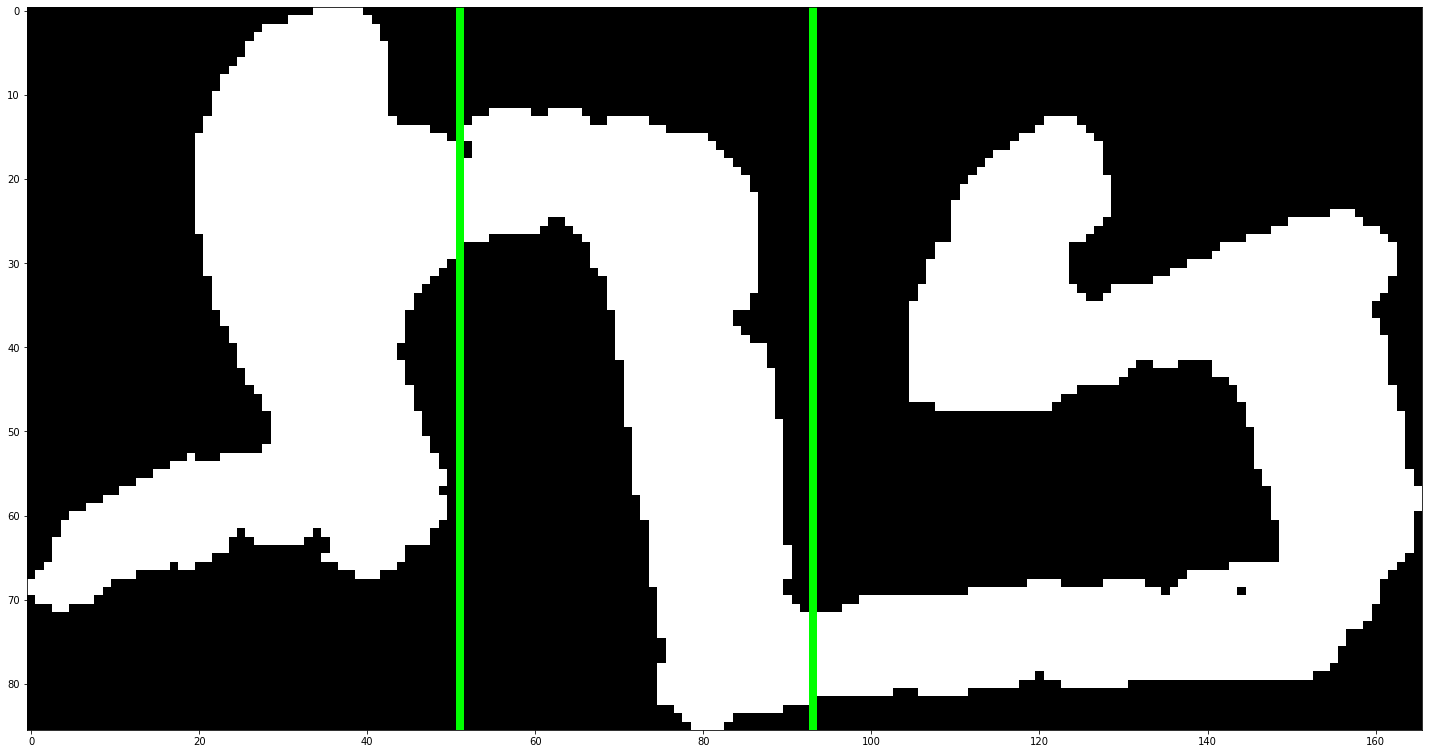

[[95, 10]]


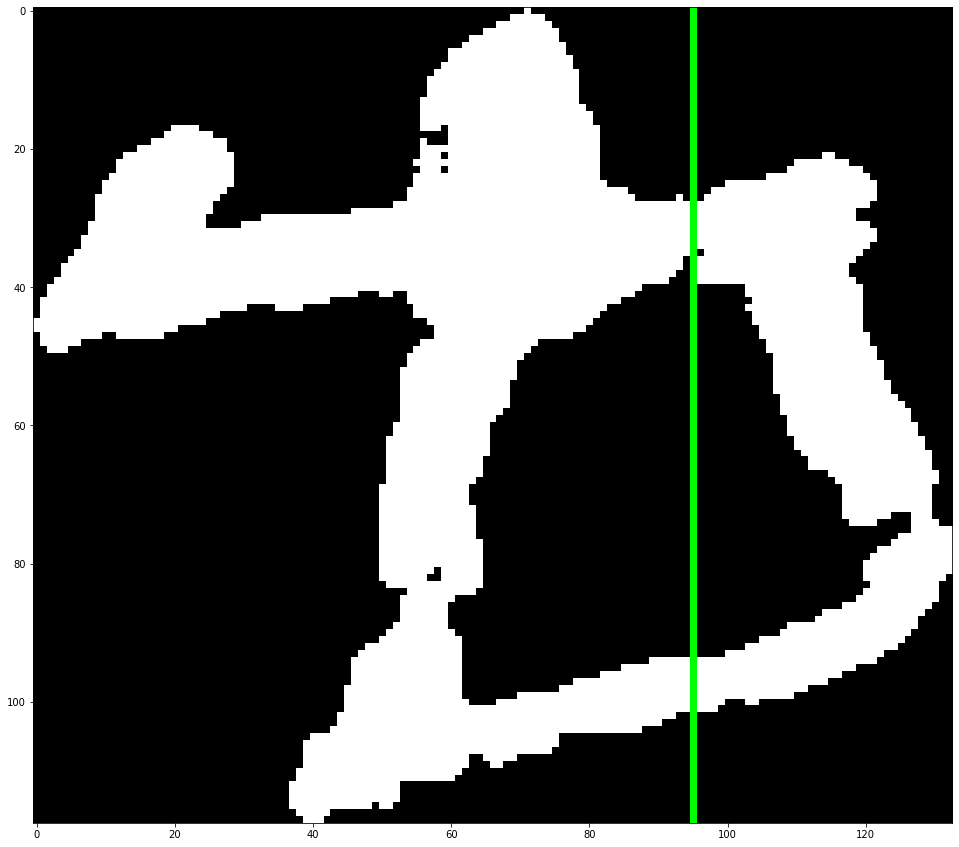

[]


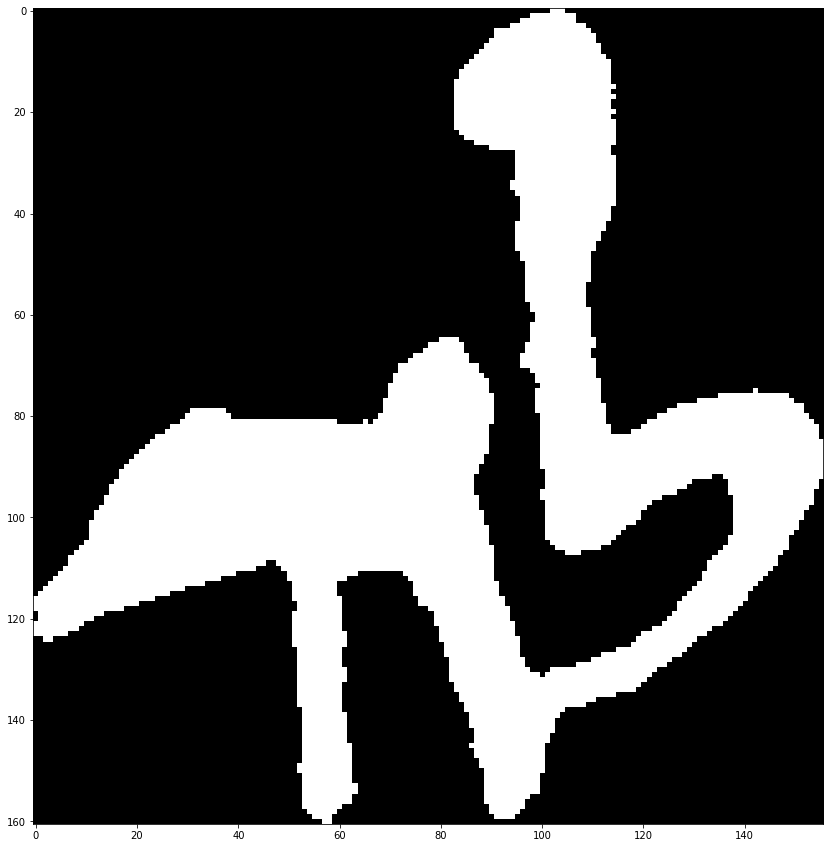

[[33, 12], [84, 5]]


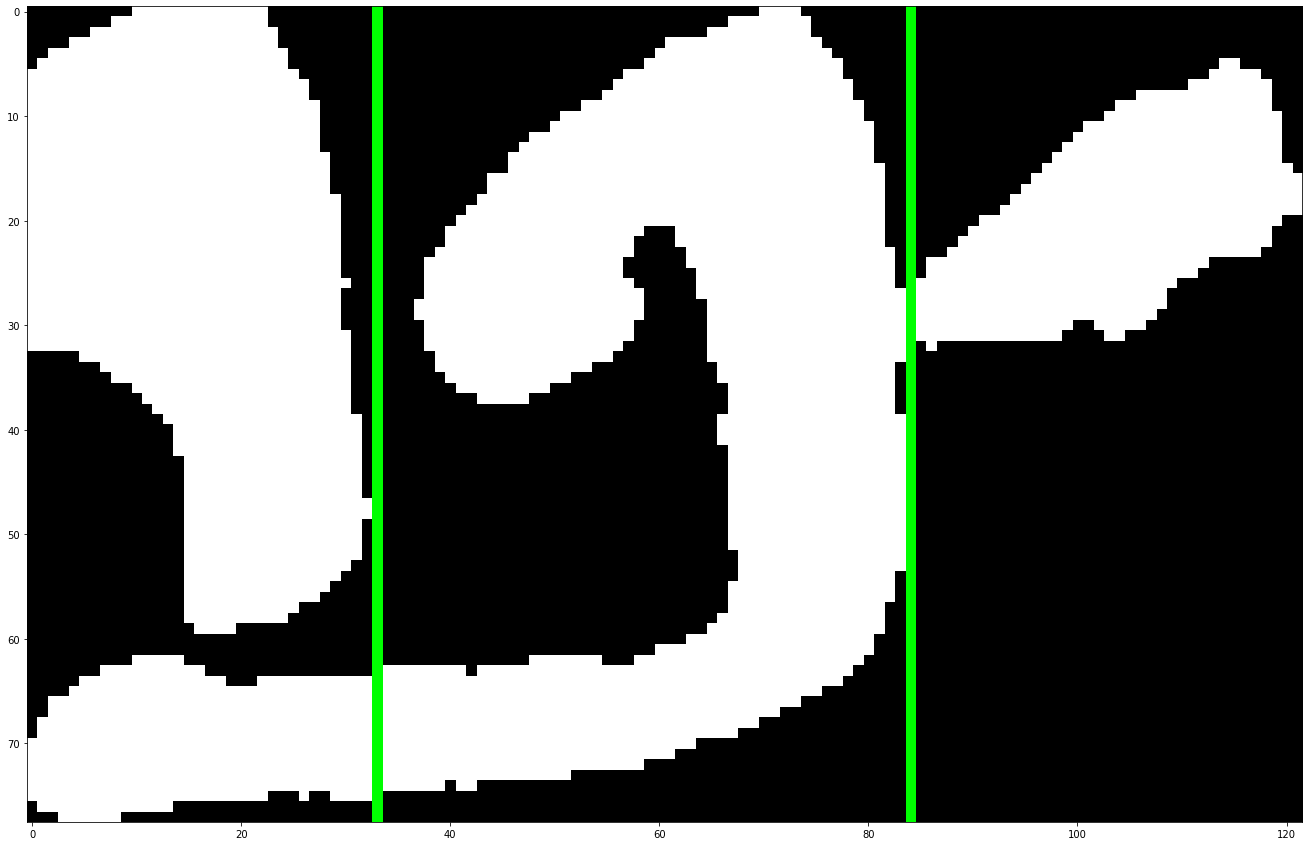

[[28, 23]]


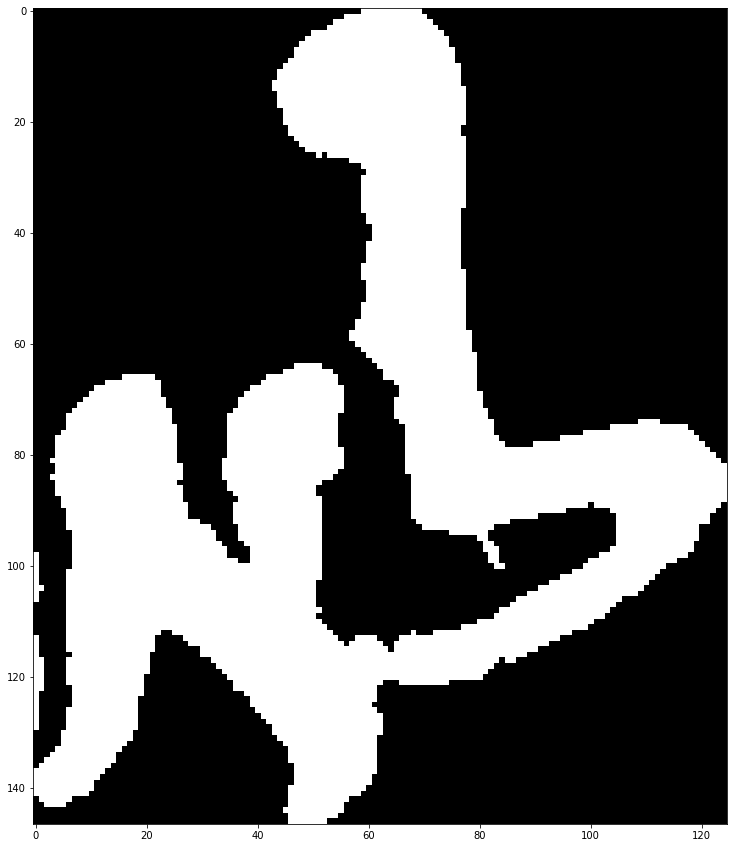

[[30, 15], [66, 9], [98, 25]]


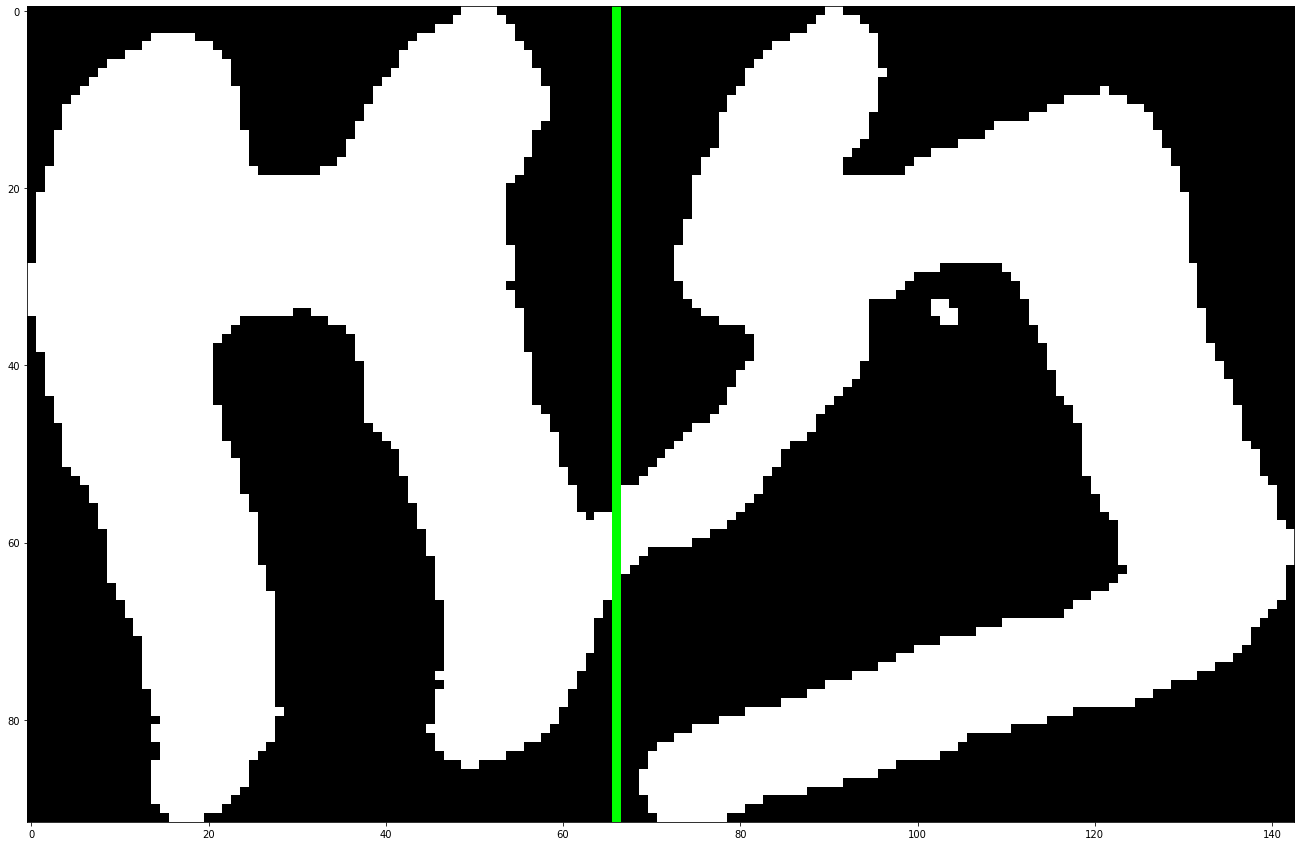

[]


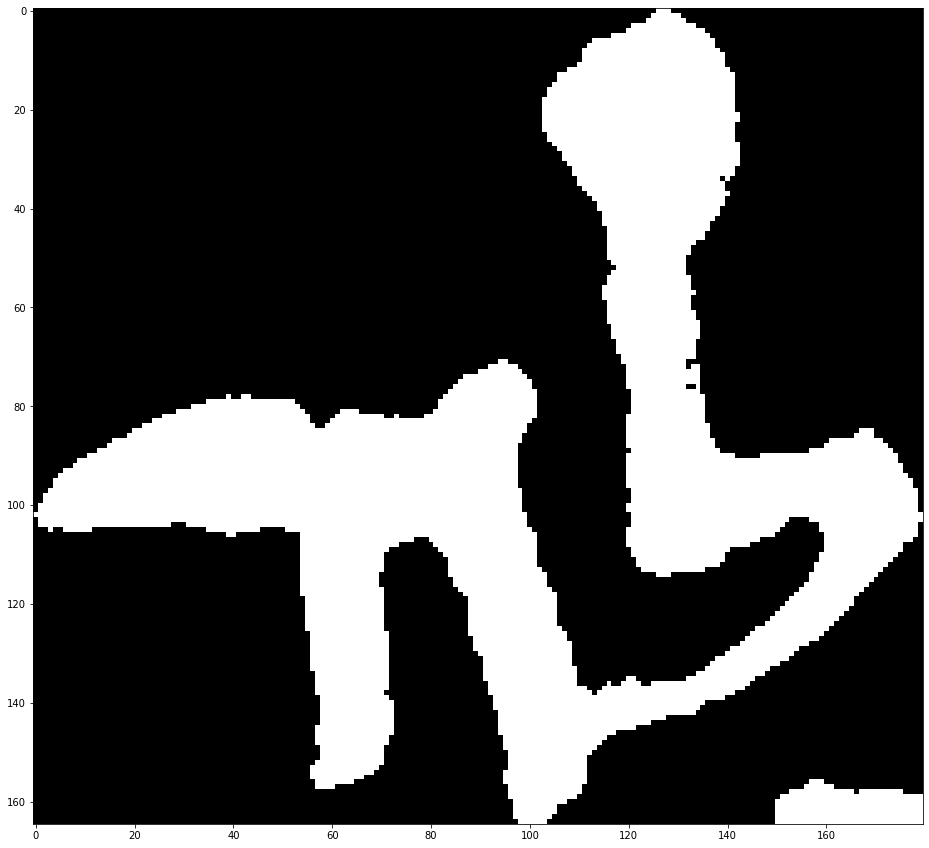

[[28, 13], [80, 16]]


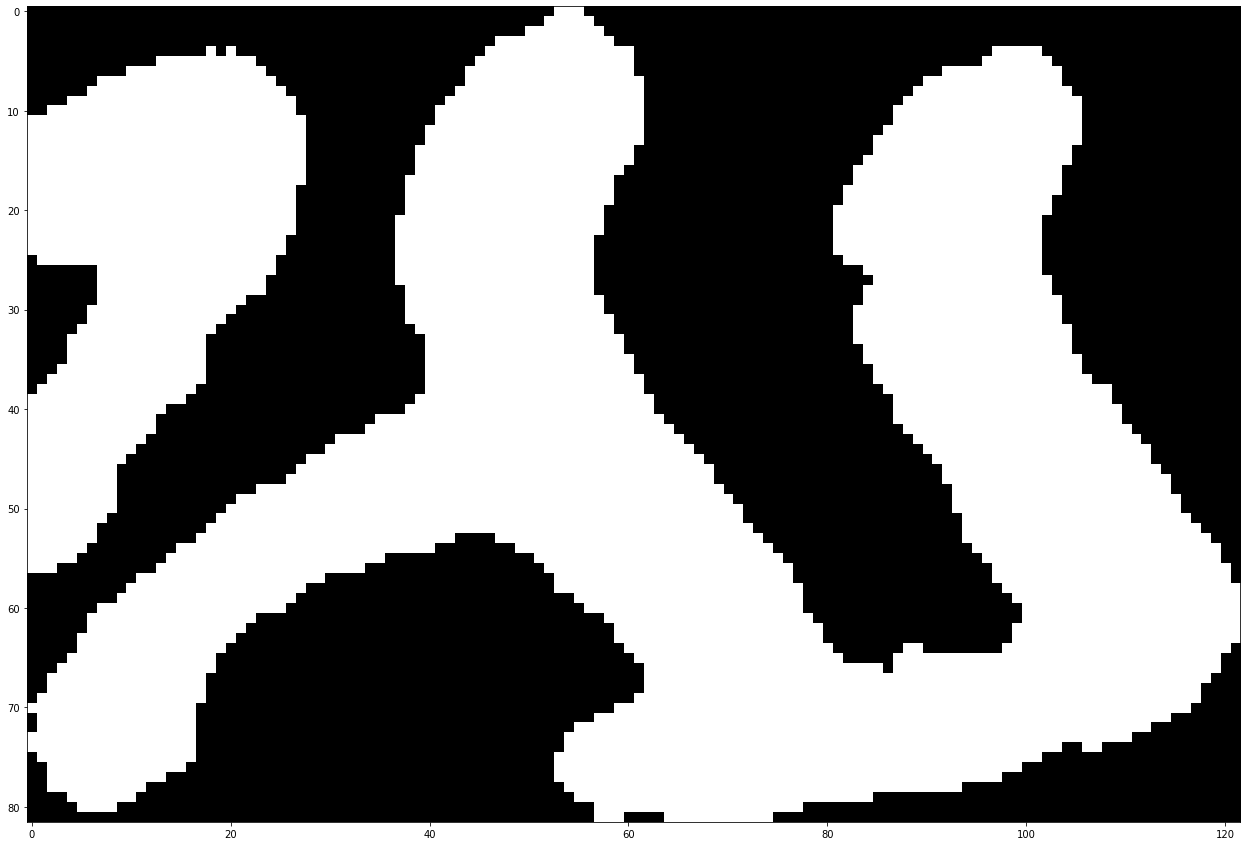

[[42, 20], [77, 10]]


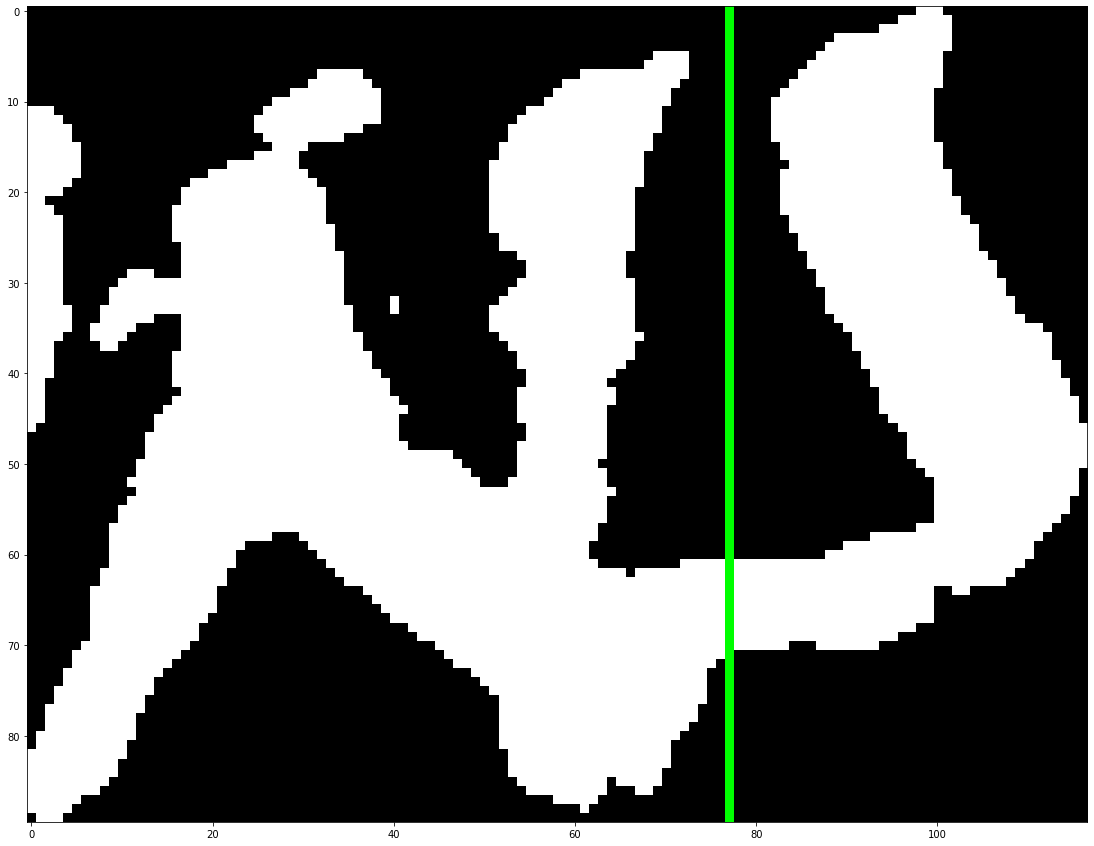

[[86, 12]]


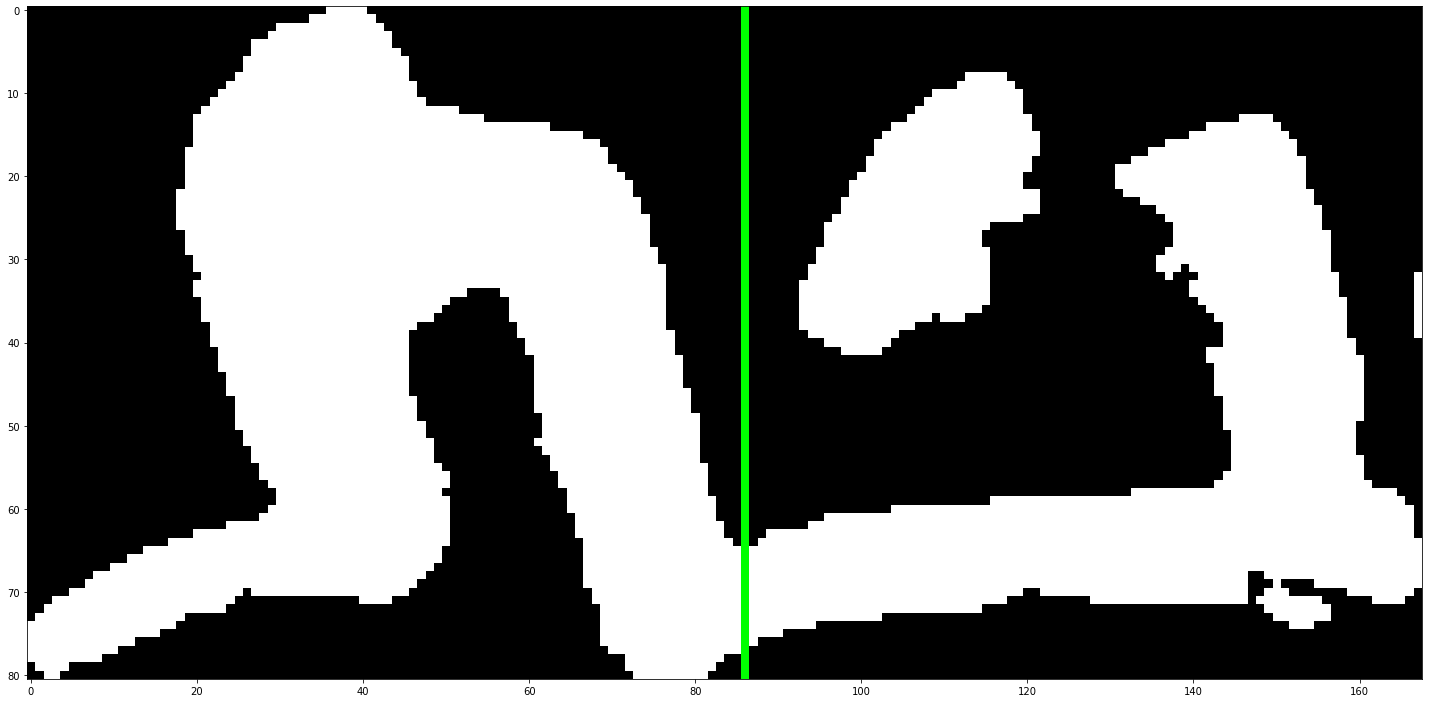

[[81, 20]]


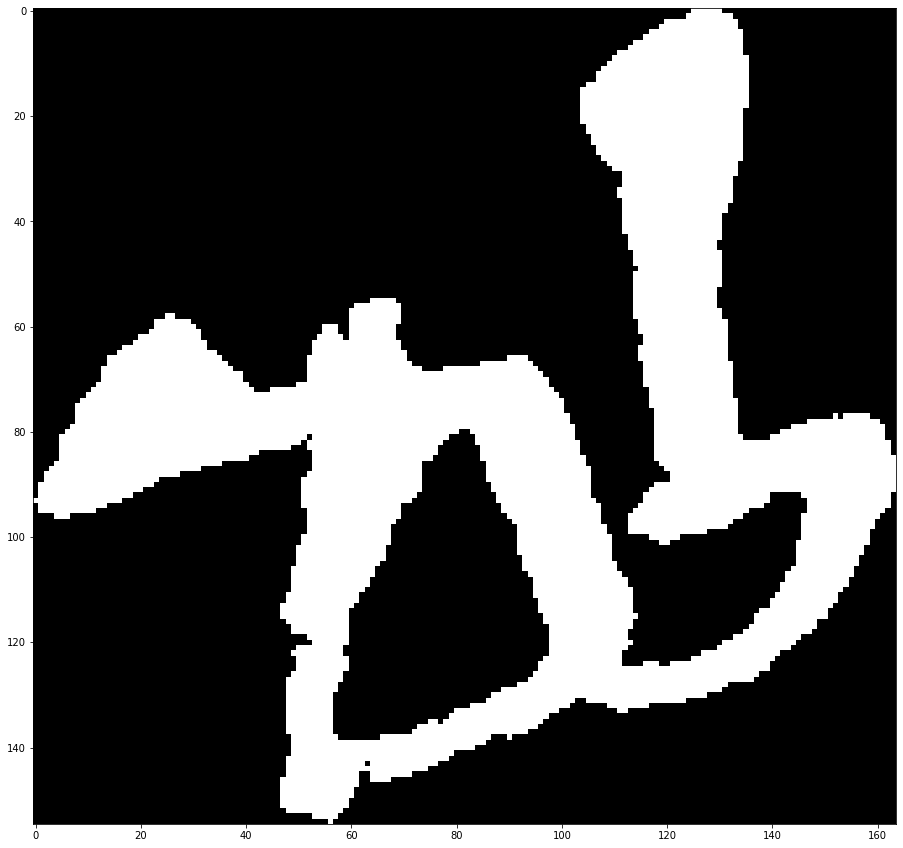

[[48, 8]]


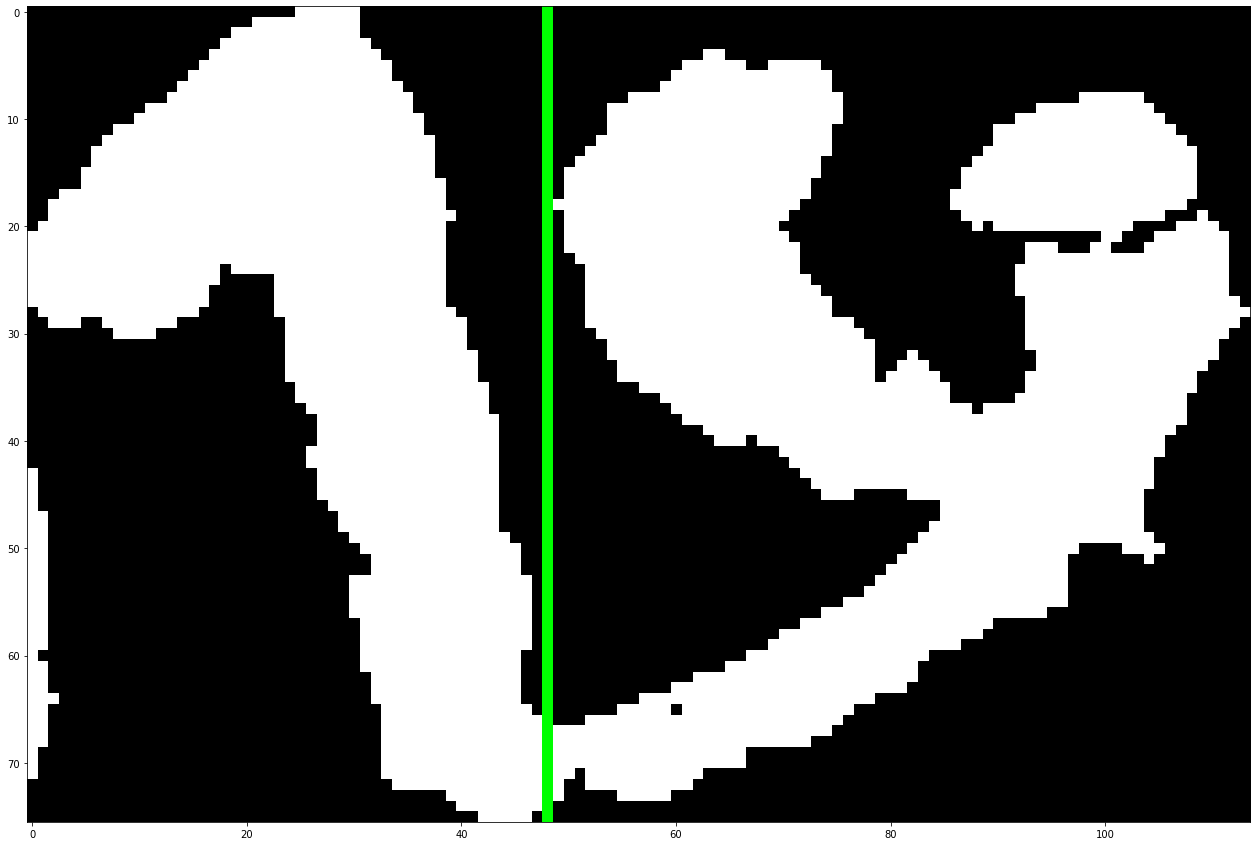

[[36, 8]]


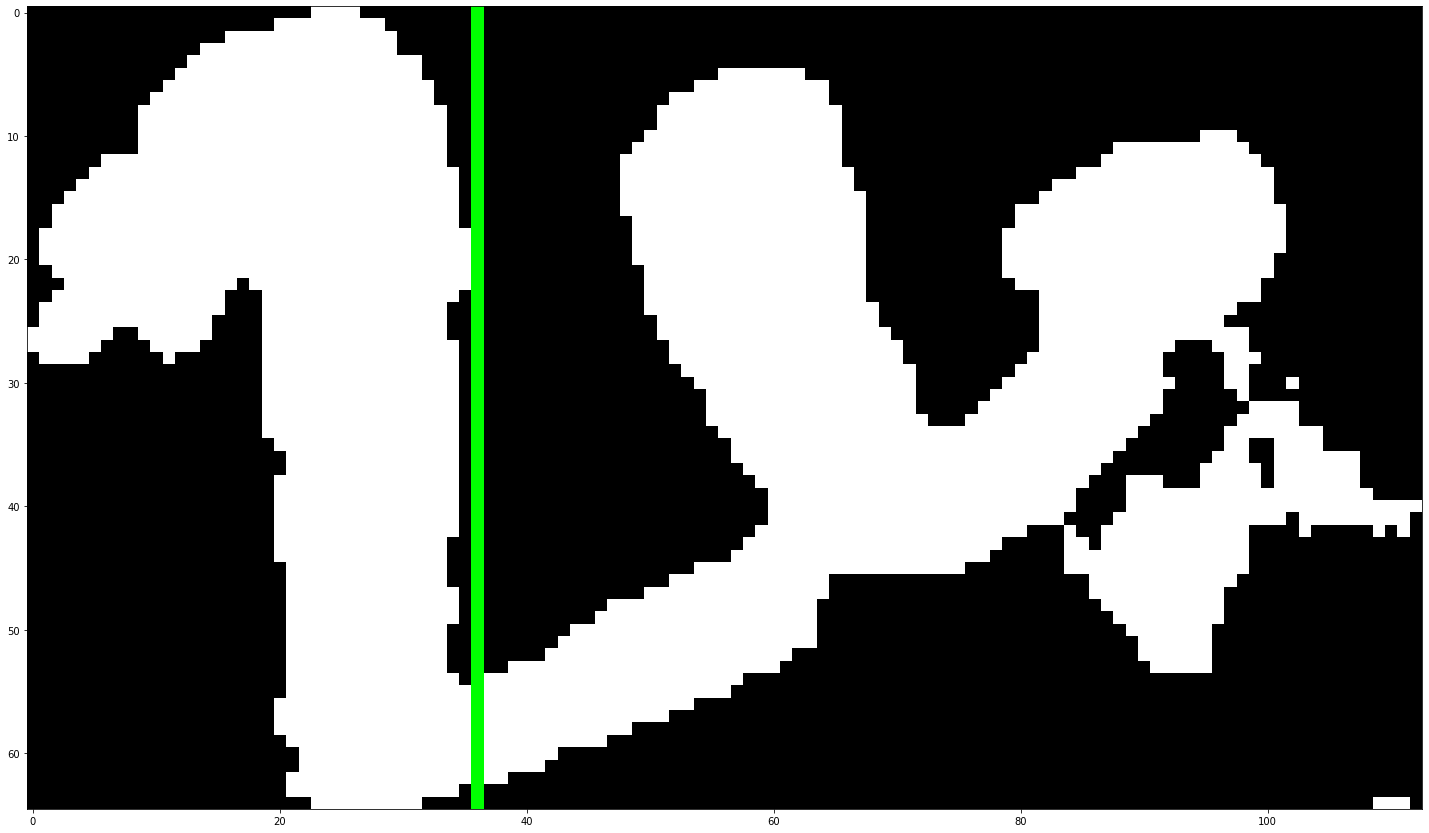

[[80, 10]]


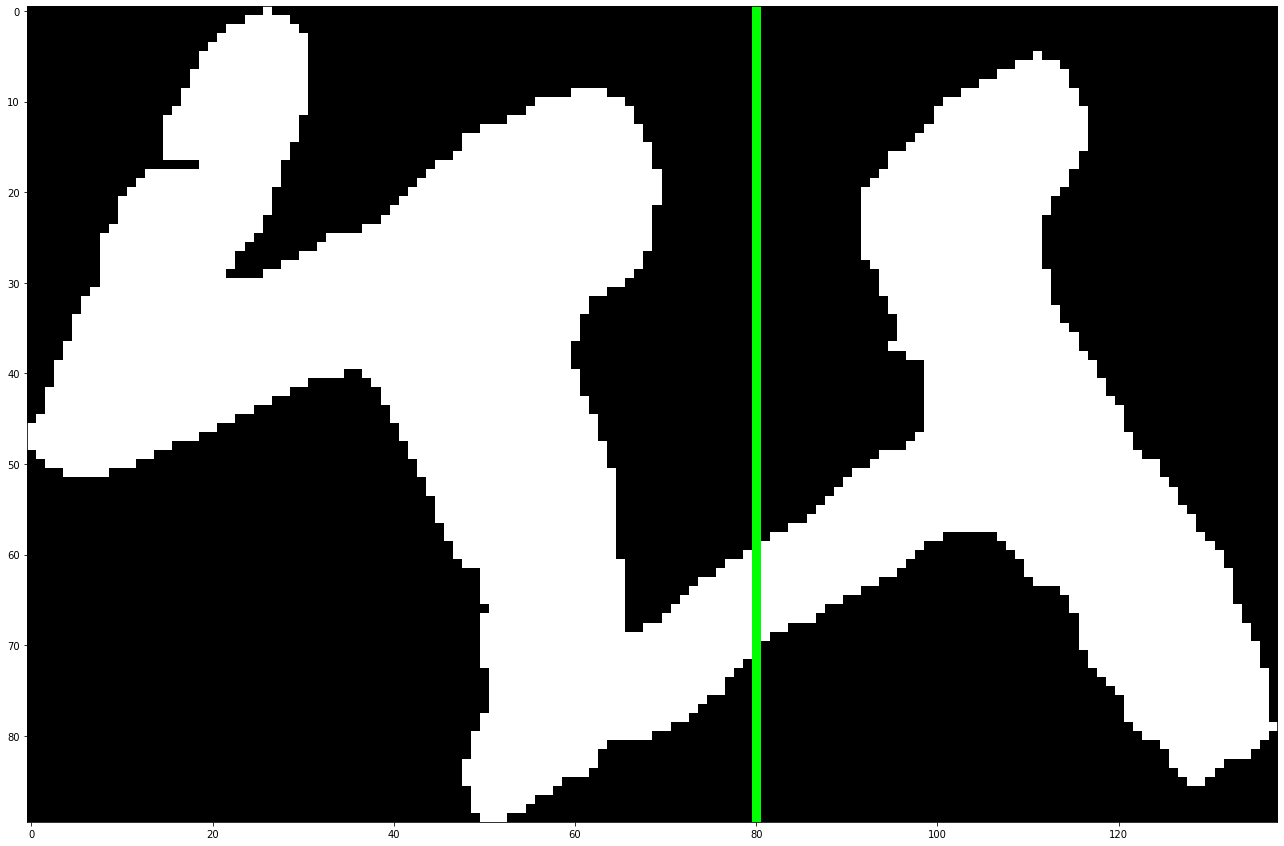

[[47, 23], [82, 26]]


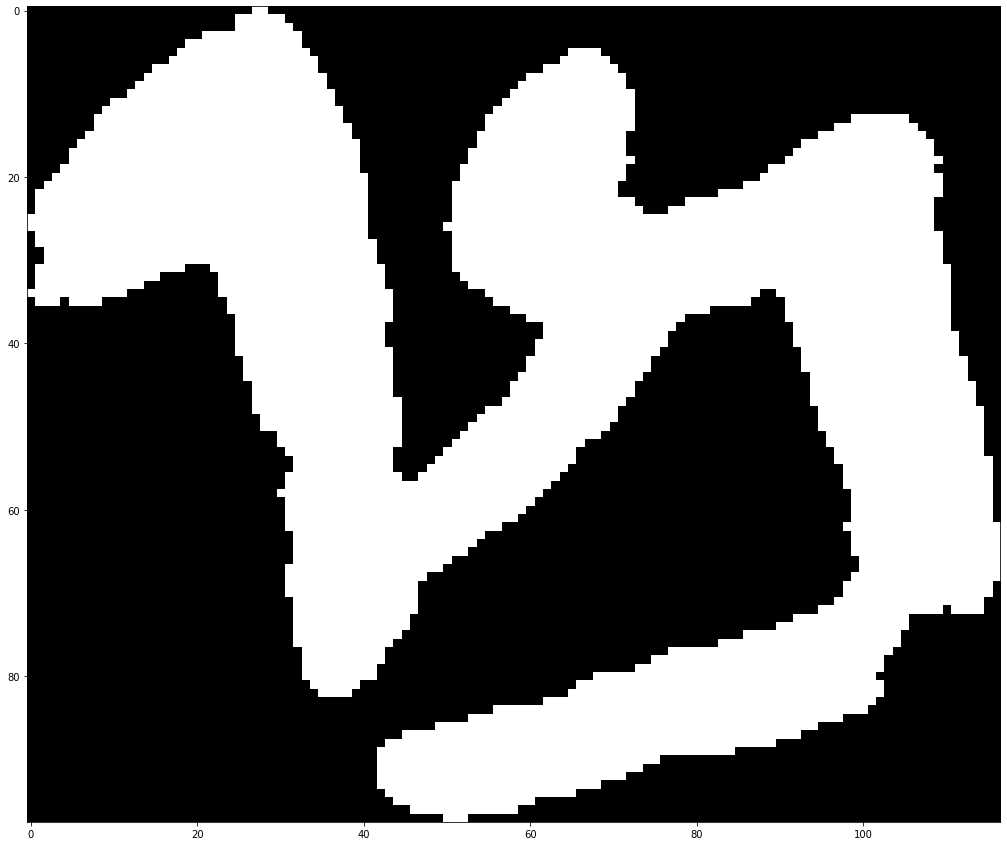

[[55, 12], [90, 27], [127, 13], [185, 24], [222, 27]]


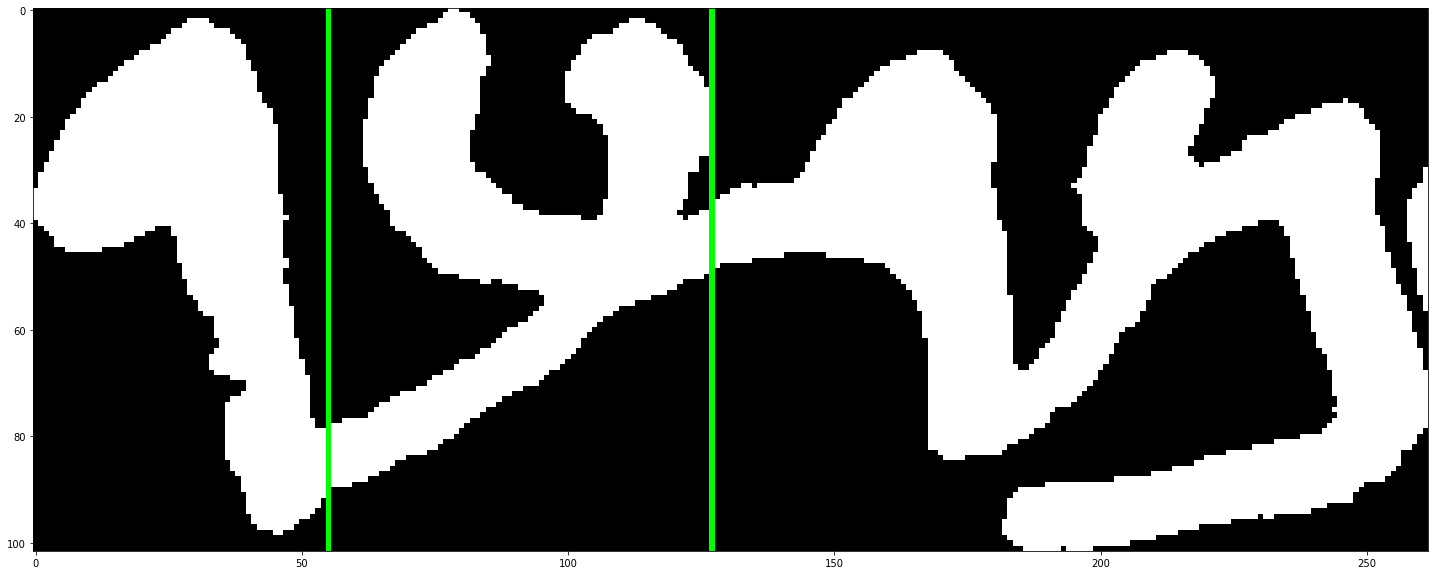

[[41, 25], [89, 9], [149, 10]]


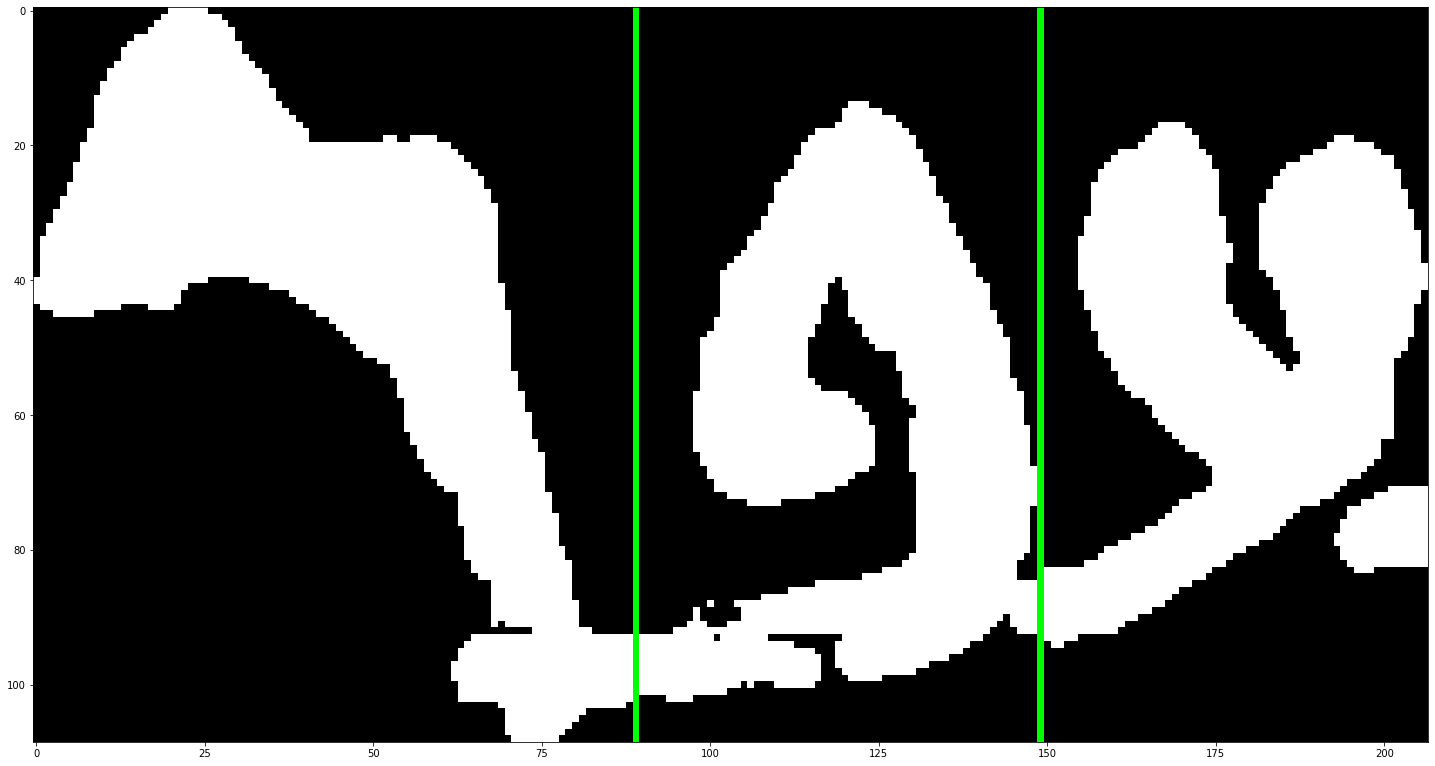

[]


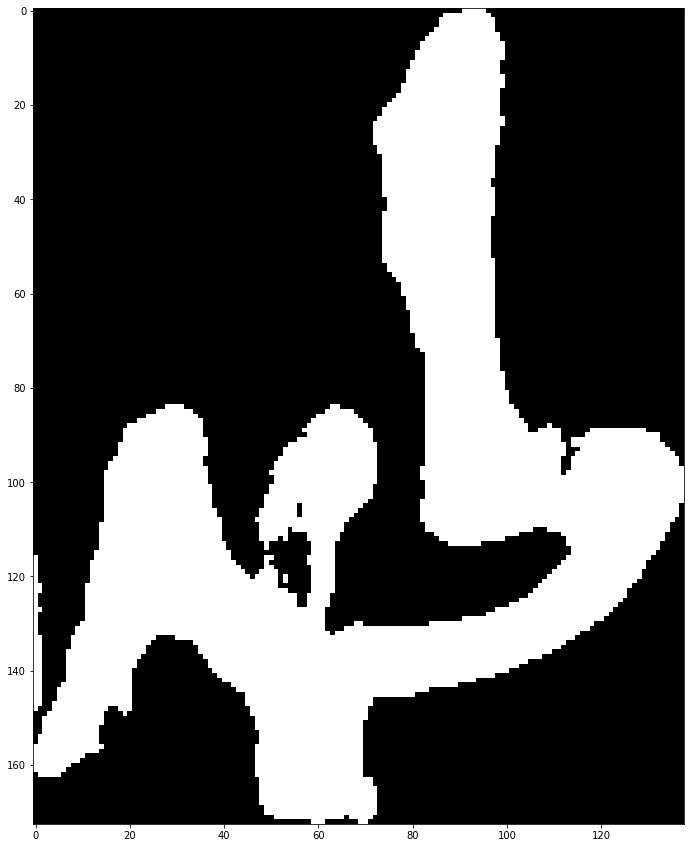

[[46, 16], [98, 14]]


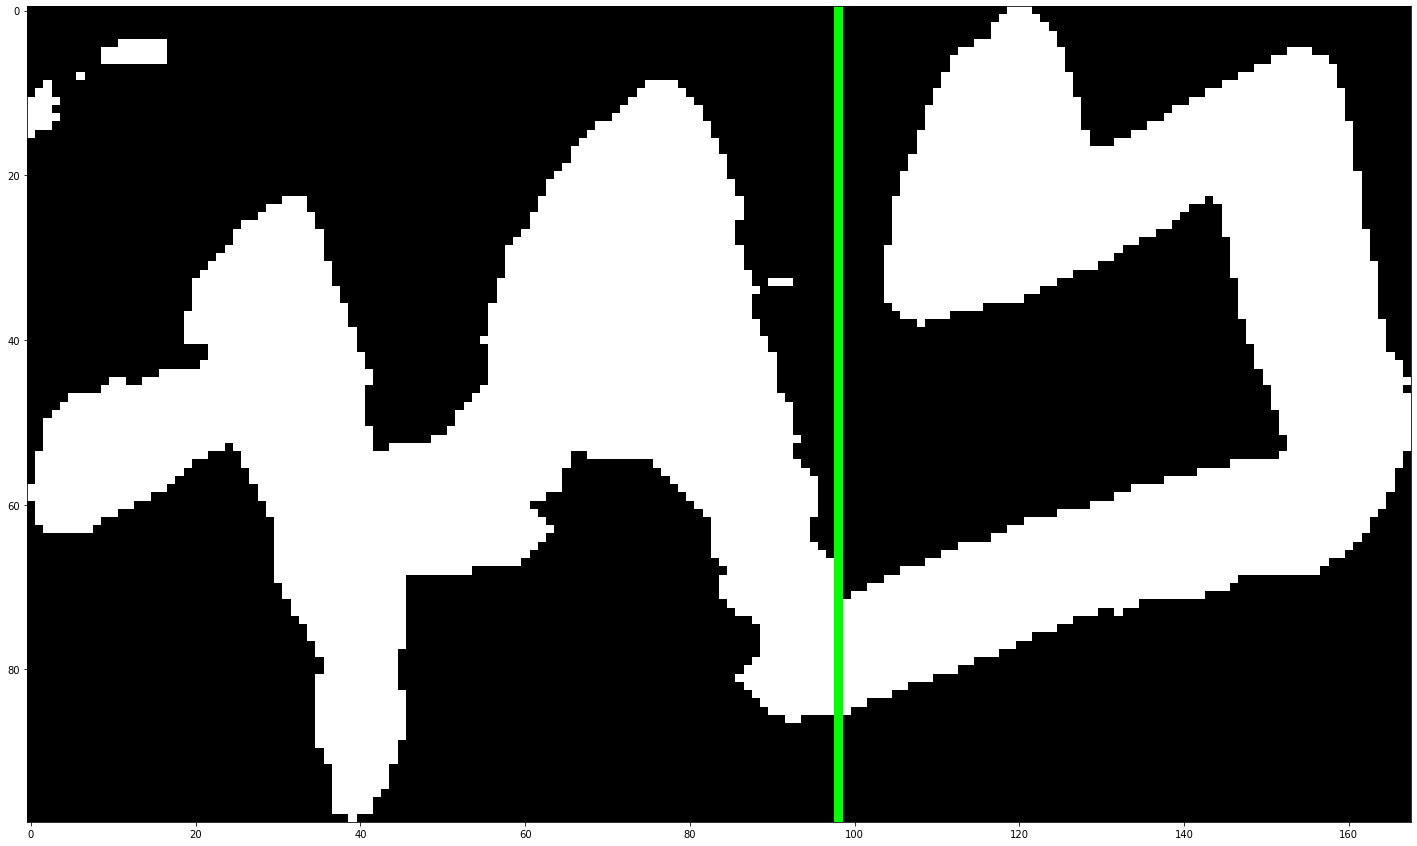

[]


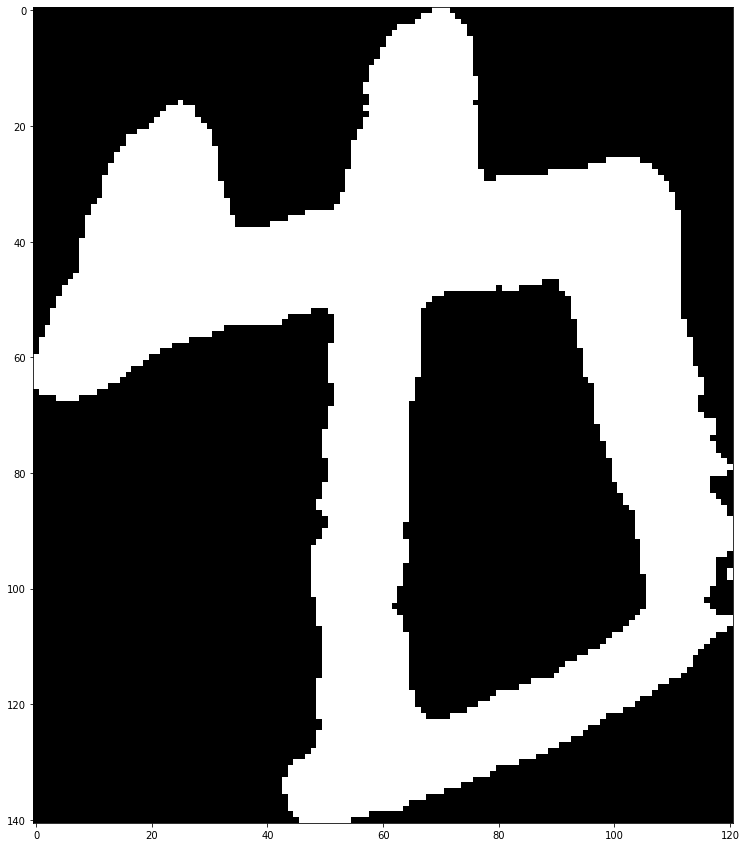

[[80, 30]]


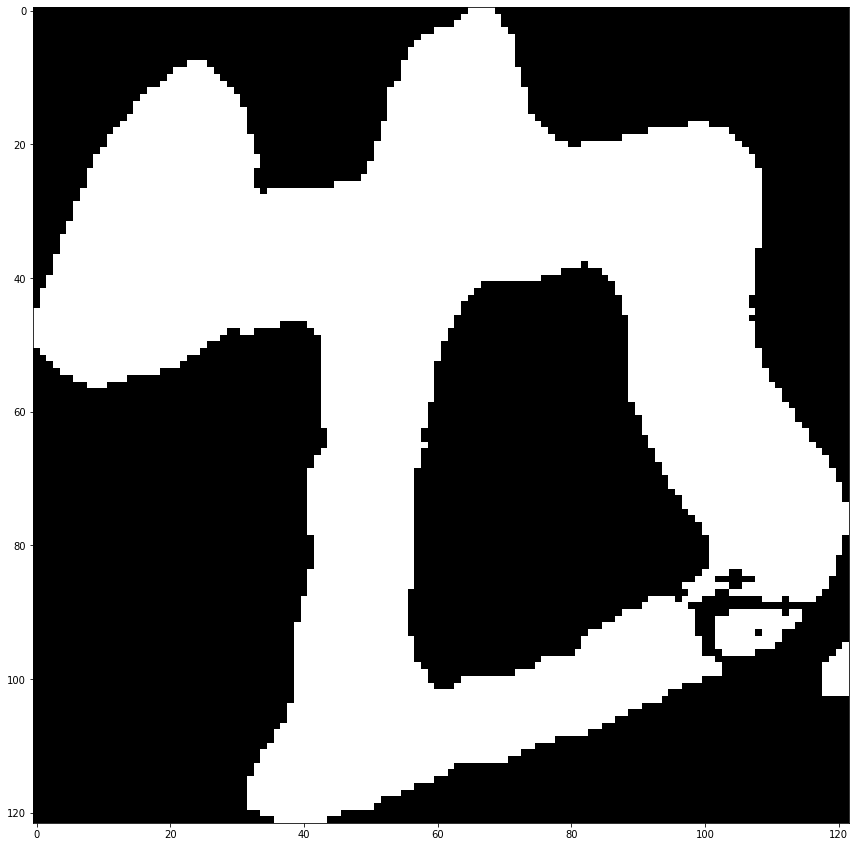

[[110, 14], [140, 24]]


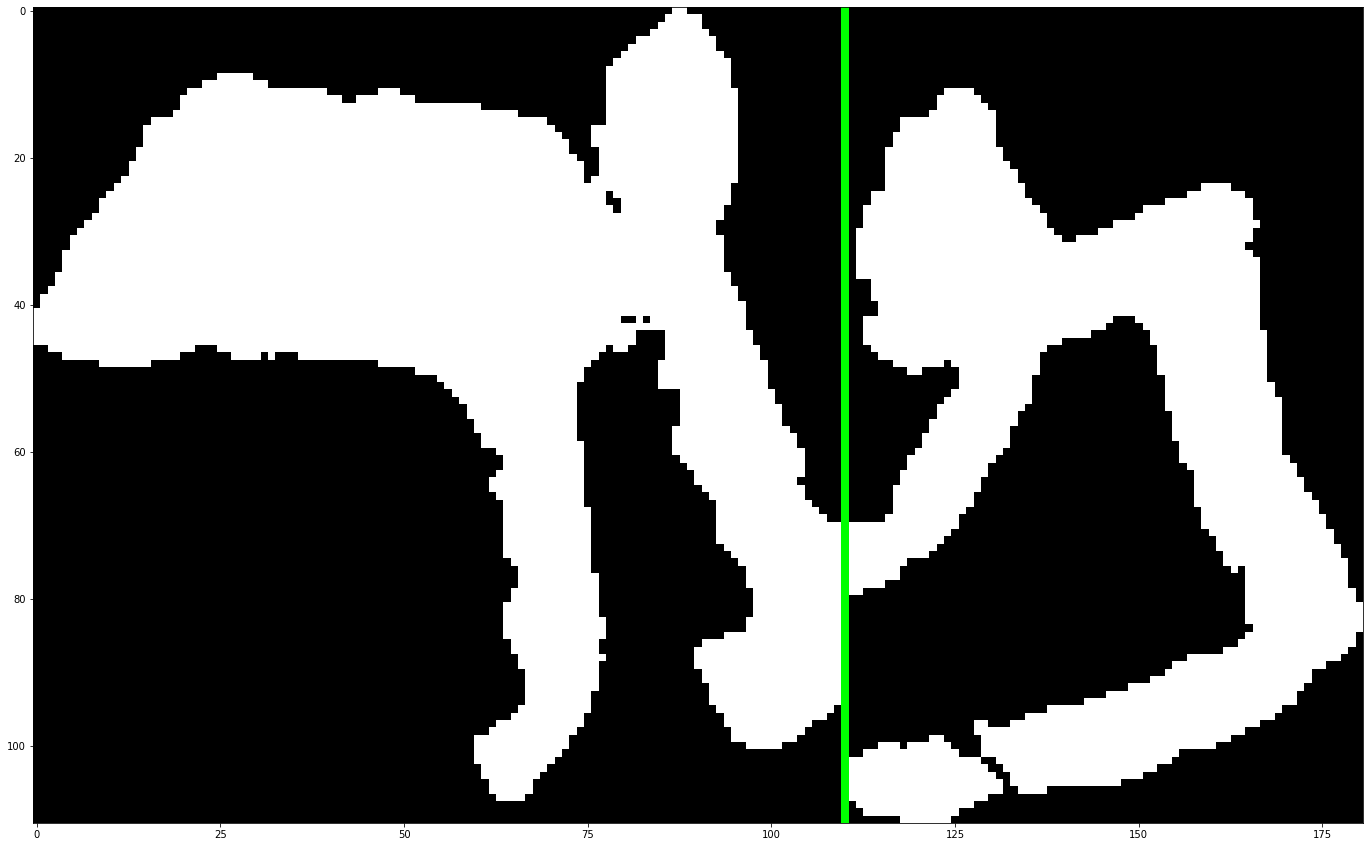

[[63, 11]]


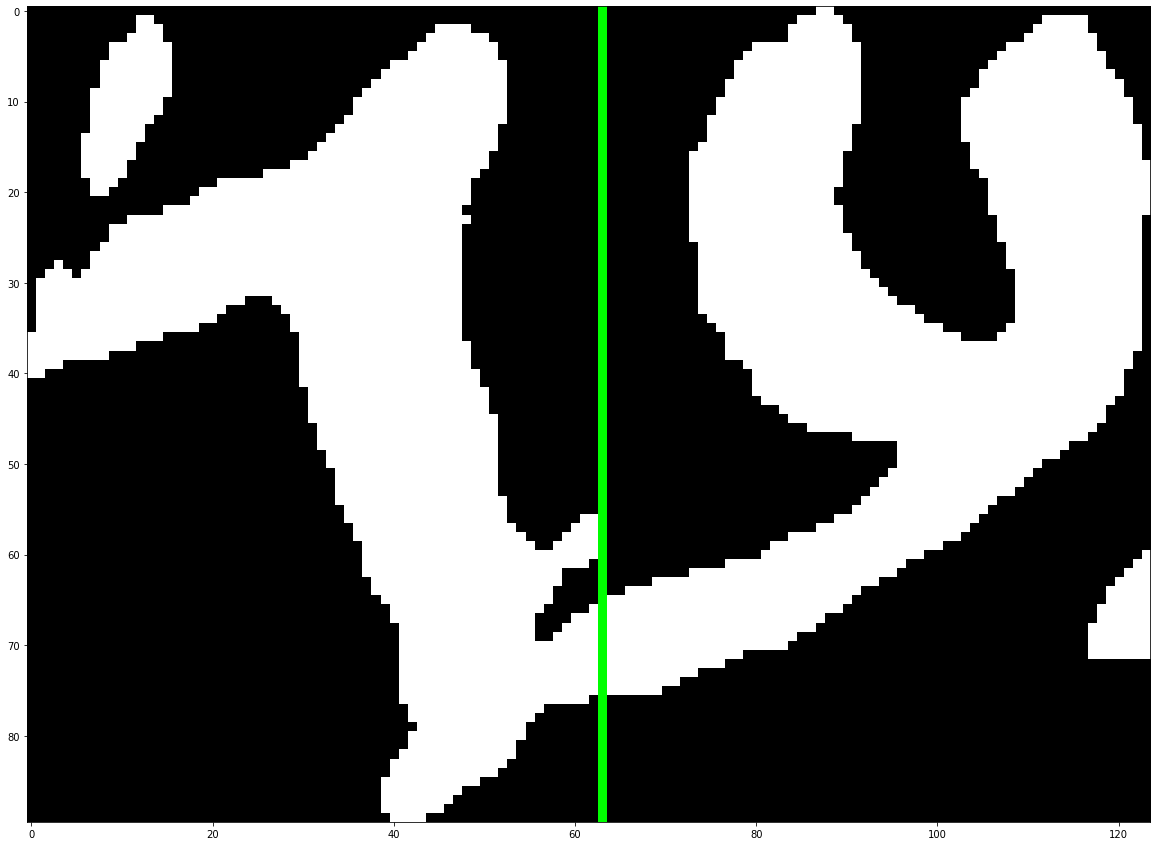

[[103, 12]]


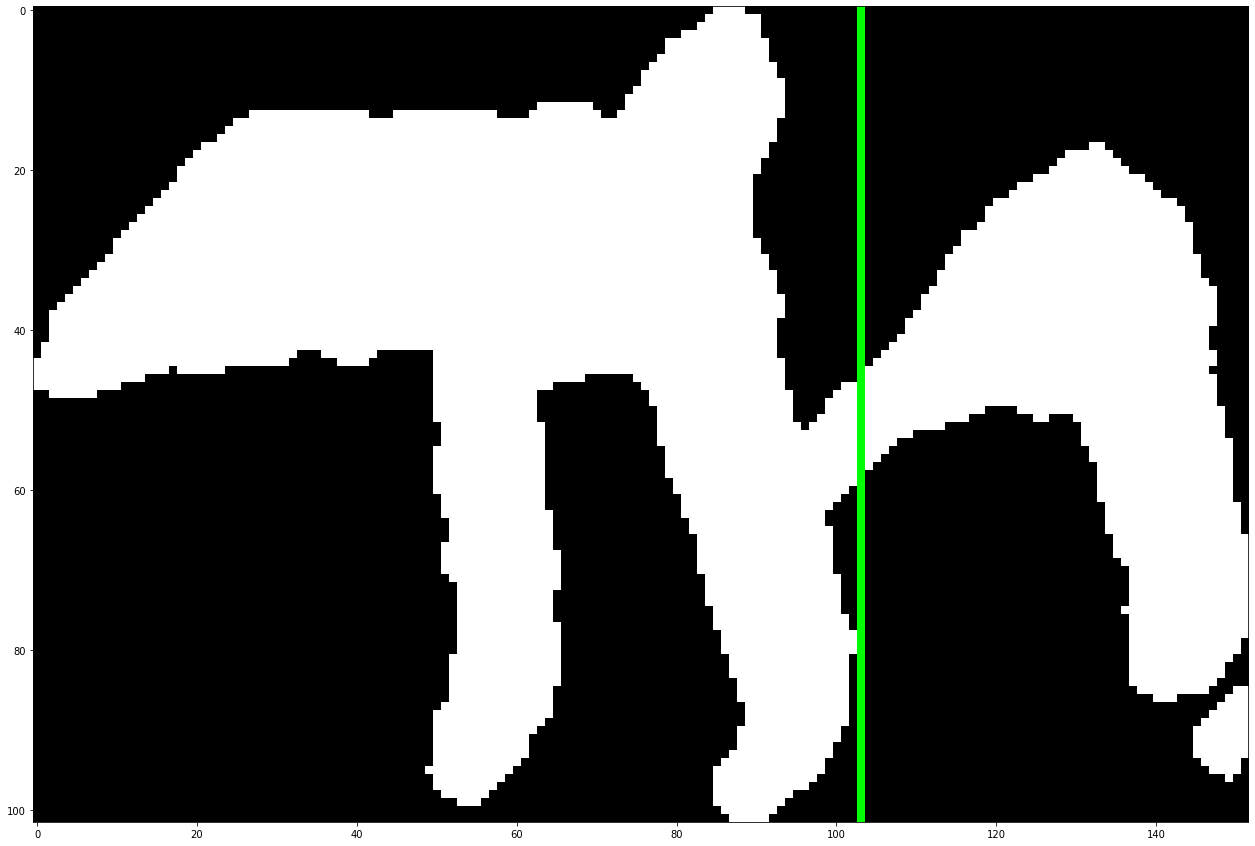

[[105, 9]]


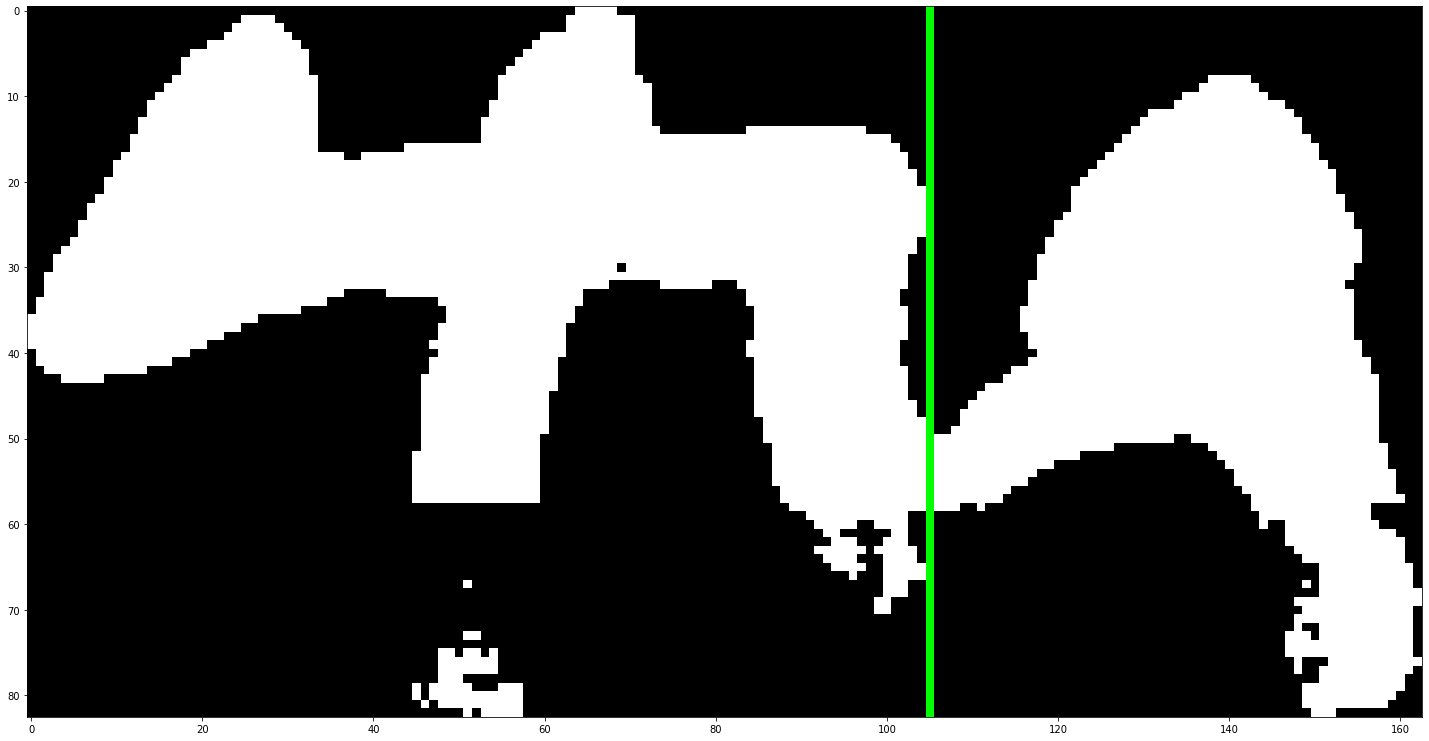

[[79, 26], [174, 14], [224, 4]]


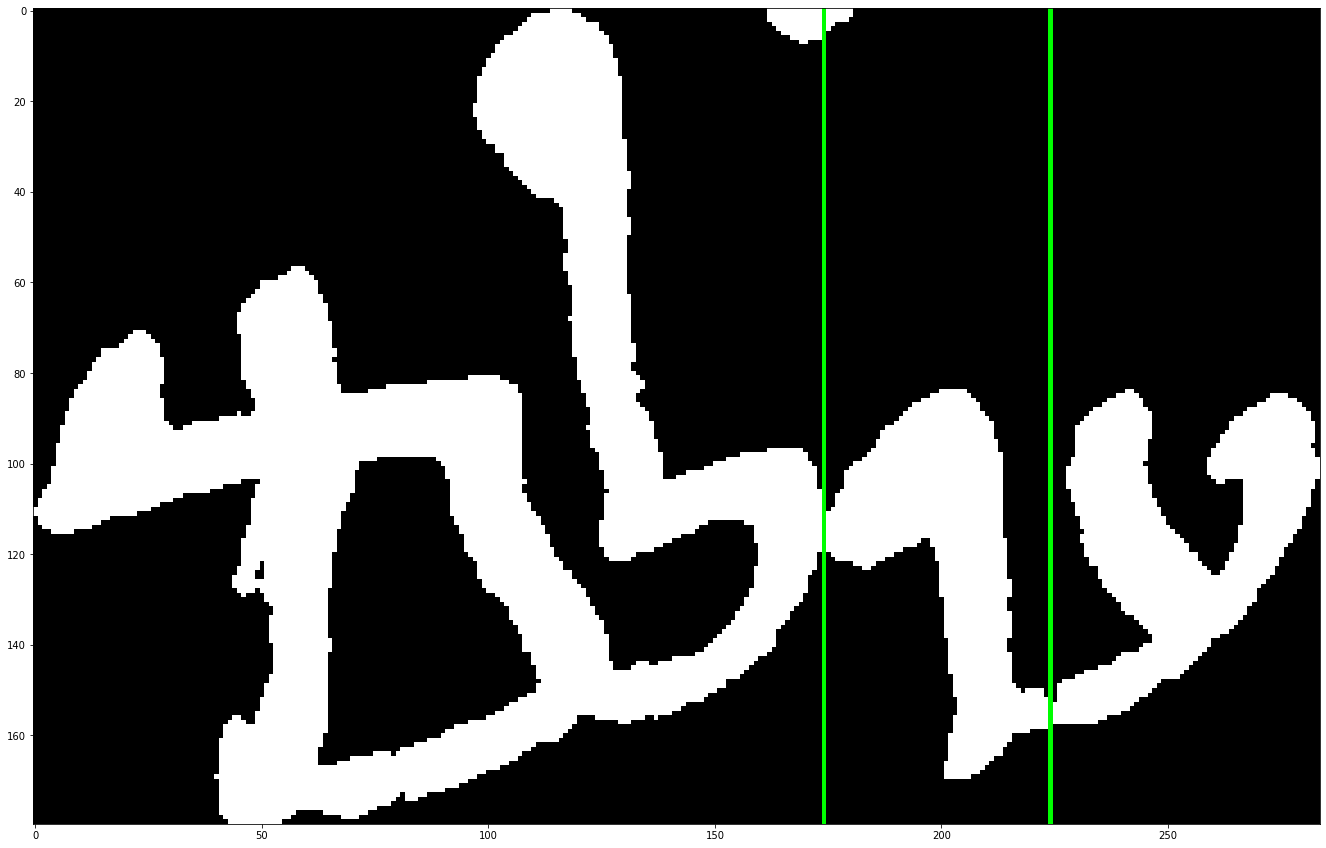

[[47, 16]]


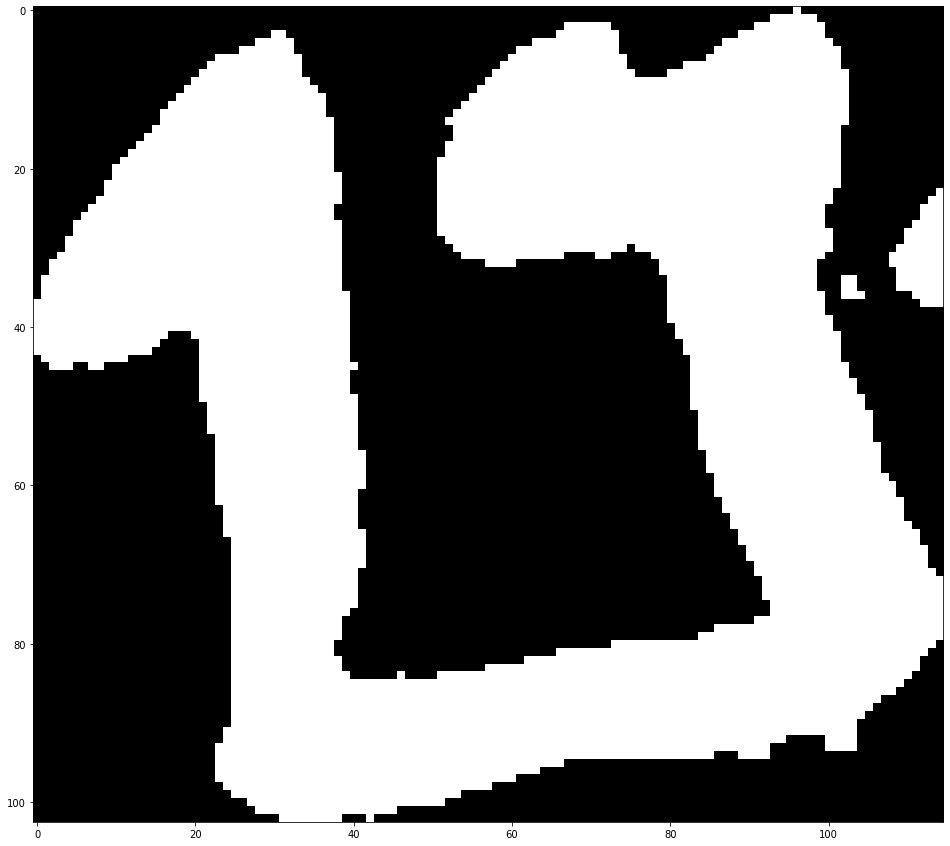

In [100]:
for cc in large_ccs:
    ccimg = cv.cvtColor(get_cc_img(cc), cv.COLOR_GRAY2RGB)
    minima = get_horiz_bound(cc)
    print(minima)
    for i, mn in enumerate(minima):
        if mn[1] < 15:
            w = ccimg.shape[0]
            prev = minima[i-1] if i>0 else [0]
            if mn[0] - prev[0] > 30:
                cv.line(ccimg, (mn[0], 0), (mn[0], 1000), (0, 255, 0), 1)

    pimg(ccimg)

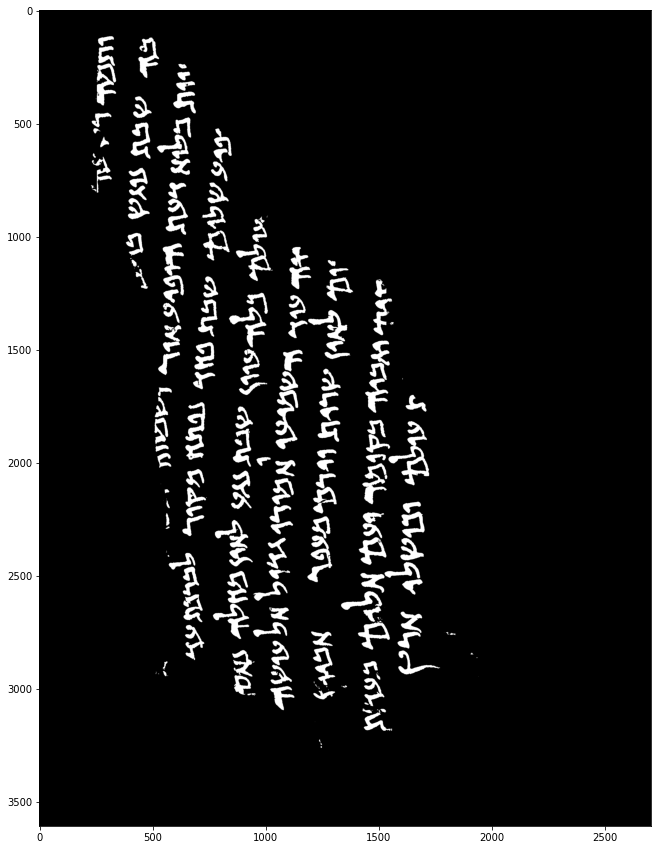

In [79]:
from scipy import ndimage
pimg(ndimage.rotate(img, 90))